<a href="https://colab.research.google.com/github/vhppacheco/ic-ita-finance-ia/blob/main/clustering/clustering_modeling_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q yfinance
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install sqldf
!pip install -q tsfeatures
!pip install umap-learn
!pip install Riskfolio-Lib
#!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
riskfolio-lib 3.3.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import requests
import pandas as pd
from time import sleep
import yfinance as yf
from bs4 import BeautifulSoup
#from selenium import webdriver
import json
import sys
import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
#chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
#chrome_options.add_argument('--no-sandbox')
#chrome_options.add_argument('--disable-dev-shm-usage')
#wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

# Concatenado (S&P & Ibov)

##Reading data

In [ ]:
df_ibov = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Ibov_Final.xlsx')
df_ibov['Indice'] = 'Ibov'
df_ibov = df_ibov.rename(columns={'Sharpe':'Sharpe Ibov'})
df_ibov = df_ibov.rename(columns={'Beta':'Beta Ibov'})

df_sp500 = pd.read_excel('/content/drive/MyDrive/IC ITA/df_SP500_Final.xlsx')
df_sp500['Indice'] = 'S&P500'
df_sp500 = df_sp500.rename(columns={'Sharpe':'Sharpe SP500'})
df_sp500 = df_sp500.rename(columns={'Beta':'Beta sp500'})

df_indicators = pd.concat([df_sp500,df_ibov])

df_indicators = df_indicators.loc[df_indicators['Código']!='BRAP4']

##EDA

In [ ]:
df_indicators.isnull().sum()

Data                                                                  0
 LiqCor  consolid:sim*                                                0
 LiqSec  consolid:sim*                                                0
 Exig / PL  consolid:sim*                                             0
 DivBr/Ebitda  de 3 meses  consolid:sim*                              0
 Margem Liquida  de 3 meses  consolid:sim*                            0
ROA de 3 meses                                                        0
ROE de 3 meses                                                        0
P/L de 3 meses ajust pela infl                                        0
Valor Mercado da empresa Em US Dollars em milhares                    0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*                0
Price/Book ratio                                                      0
EV Em US Dollars em milhares consolid:sim*                            0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*            

In [ ]:
#Cria as colunas de sharpe ratio e beta unindo o sp500 e ibov
df_indicators['Sharpe Ratio'] = df_indicators['Sharpe Ibov'].fillna(0) + df_indicators['Sharpe SP500'].fillna(0)
df_indicators['Beta'] = df_indicators['Beta Ibov'].fillna(0) + df_indicators['Beta sp500'].fillna(0)
df_indicators.drop(['Sharpe Ibov','Sharpe SP500','Beta Ibov','Beta sp500'],axis='columns',inplace=True)

In [ ]:
df_indicators.isna().sum()

Data                                                              0
 LiqCor  consolid:sim*                                            0
 LiqSec  consolid:sim*                                            0
 Exig / PL  consolid:sim*                                         0
 DivBr/Ebitda  de 3 meses  consolid:sim*                          0
 Margem Liquida  de 3 meses  consolid:sim*                        0
ROA de 3 meses                                                    0
ROE de 3 meses                                                    0
P/L de 3 meses ajust pela infl                                    0
Valor Mercado da empresa Em US Dollars em milhares                0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*            0
Price/Book ratio                                                  0
EV Em US Dollars em milhares consolid:sim*                        0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*              0
P/FCF Em US Dollars de 3 meses consolid:sim*    

In [ ]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators['Código ajustado']=df_indicators['Código']
df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado'] = df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado']+str('.SA')

In [ ]:
df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10) 

Data   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
1697  2T2020                1.171241                0.793256   
253   2T2019                0.826152                1.627830   
233   2T2020                1.090801                0.781532   
1134  3T2017                1.105365                0.654432   
65    2T2020                2.104166                1.823111   
1758  3T2017                2.267484                2.267484   
261   2T2021                0.765141                1.627830   
1347  4T2016                9.816378                9.399498   
1348  1T2017                3.672323                3.421612   
1361  2T2020                0.733932                0.602881   

       Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
1697                   4.741137                                 15.680451   
253                    6.147602                                  8.758159   
233                    7.880433                                 14.454332   
1134                   5.900982                                  6.417938   
65                     1.952323                                 42.783600   
1758                   0.522348                                  3.830376   
261                    6.678682                                  8.758159   
1347                   0.297568                                  0.090572   
1348                   0.547889                                453.155963   
1361                   1.580456                                  8.789388   

       Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
1697                                    0.012311        0.002242   
253                                     0.057867        0.003896   
233                                     0.201766        0.004377   
1134                                    0.032379        0.015551   
65                                     -0.030654       -0.004536   
1758                                    0.184755        0.033976   
261                                     0.073872        0.004744   
1347                                    2.519452        0.264753   
1348                                    0.053740        0.002870   
1361                                   -0.319578       -0.014984   

      ROE de 3 meses  P/L de 3 meses ajust pela infl  \
1697        0.012874                      319.899453   
253         0.027849                       86.624658   
233         0.038870                       68.123789   
1134        0.107317                      137.034134   
65         -0.013393                     -750.806848   
1758        0.051724                       64.183647   
261         0.036428                      143.189126   
1347        0.343535                        1.002528   
1348        0.004443                      153.696119   
1361       -0.038665                      -47.928341   

      Valor Mercado da empresa Em US Dollars em milhares  ...  \
1697                                       4.463321e+06   ...   
253                                        2.660698e+06   ...   
233                                        1.563549e+07   ...   
1134                                       4.427051e+06   ...   
65                                         1.022858e+07   ...   
1758                                       3.024822e+06   ...   
261                                        5.796180e+06   ...   
1347                                       8.786412e+04   ...   
1348                                       1.919249e+05   ...   
1361                                       8.735106e+05   ...   

      Volatilidade base trimestral 3 meses Em moeda orig  \
1697                                           0.473970    
253                                            0.425204    
233                                            0.374168    
1134                                           0.348765    
65                                             0.415859    
1758         

In [ ]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912 entries, 0 to 1775
Data columns (total 28 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   Data                                                            12912 non-null  object        
 1    LiqCor  consolid:sim*                                          12912 non-null  float64       
 2    LiqSec  consolid:sim*                                          12912 non-null  float64       
 3    Exig / PL  consolid:sim*                                       12912 non-null  float64       
 4    DivBr/Ebitda  de 3 meses  consolid:sim*                        12912 non-null  float64       
 5    Margem Liquida  de 3 meses  consolid:sim*                      12912 non-null  float64       
 6   ROA de 3 meses                                                  12912 non-null  float64

In [ ]:
#normaliza as colunas de formato float
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators[column] = (df_indicators[column]-min(df_indicators[column].dropna())) /(max(df_indicators[column].dropna())-min(df_indicators[column].dropna()))

In [ ]:
best_10_sharpe = df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10)['Código ajustado']
df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10)

Data   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
1697  2T2020                0.022548                0.015583   
253   2T2019                0.014977                0.033869   
233   2T2020                0.020783                0.015326   
1134  3T2017                0.021103                0.012541   
65    2T2020                0.043017                0.038148   
1758  3T2017                0.046600                0.047885   
261   2T2021                0.013638                0.033869   
1347  4T2016                0.212226                0.204153   
1348  1T2017                0.077423                0.073173   
1361  2T2020                0.012953                0.011412   

       Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
1697                   0.310960                                  0.118206   
253                    0.311115                                  0.117759   
233                    0.311306                                  0.118127   
1134                   0.311088                                  0.117608   
65                     0.310653                                  0.119956   
1758                   0.310495                                  0.117440   
261                    0.311174                                  0.117759   
1347                   0.310471                                  0.117199   
1348                   0.310498                                  0.146458   
1361                   0.310612                                  0.117761   

       Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
1697                                    0.917501        0.532881   
253                                     0.917596        0.534910   
233                                     0.917895        0.535500   
1134                                    0.917543        0.549212   
65                                      0.917412        0.524562   
1758                                    0.917859        0.571823   
261                                     0.917629        0.535950   
1347                                    0.922706        0.855018   
1348                                    0.917587        0.533651   
1361                                    0.916812        0.511741   

      ROE de 3 meses  P/L de 3 meses ajust pela infl  \
1697        0.327435                        0.032538   
253         0.327872                        0.032386   
233         0.328193                        0.032374   
1134        0.330187                        0.032419   
65          0.326670                        0.031839   
1758        0.328567                        0.032371   
261         0.328121                        0.032423   
1347        0.337068                        0.032330   
1348        0.327190                        0.032430   
1361        0.325934                        0.032298   

      Valor Mercado da empresa Em US Dollars em milhares  ...  \
1697                                           0.001520   ...   
253                                            0.000901   ...   
233                                            0.005355   ...   
1134                                           0.001507   ...   
65                                             0.003499   ...   
1758                                           0.001026   ...   
261                                            0.001977   ...   
1347                                           0.000018   ...   
1348                                           0.000054   ...   
1361                                           0.000288   ...   

      Volatilidade base trimestral 3 meses Em moeda orig  \
1697                                           0.306706    
253                                            0.274484    
233                                            0.240763    
1134                                           0.223978    
65                                             0.268310    
1758         

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


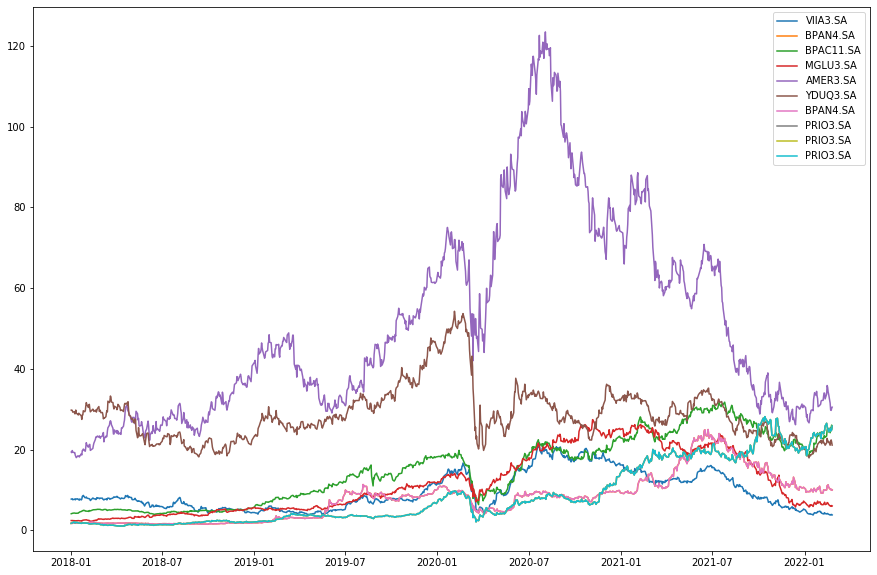

In [ ]:
for i in range(0,len(best_10_sharpe)):
  plt.plot(pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2022-02-28')['Adj Close']),label=str(best_10_sharpe.iloc[i]))
  plt.legend()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


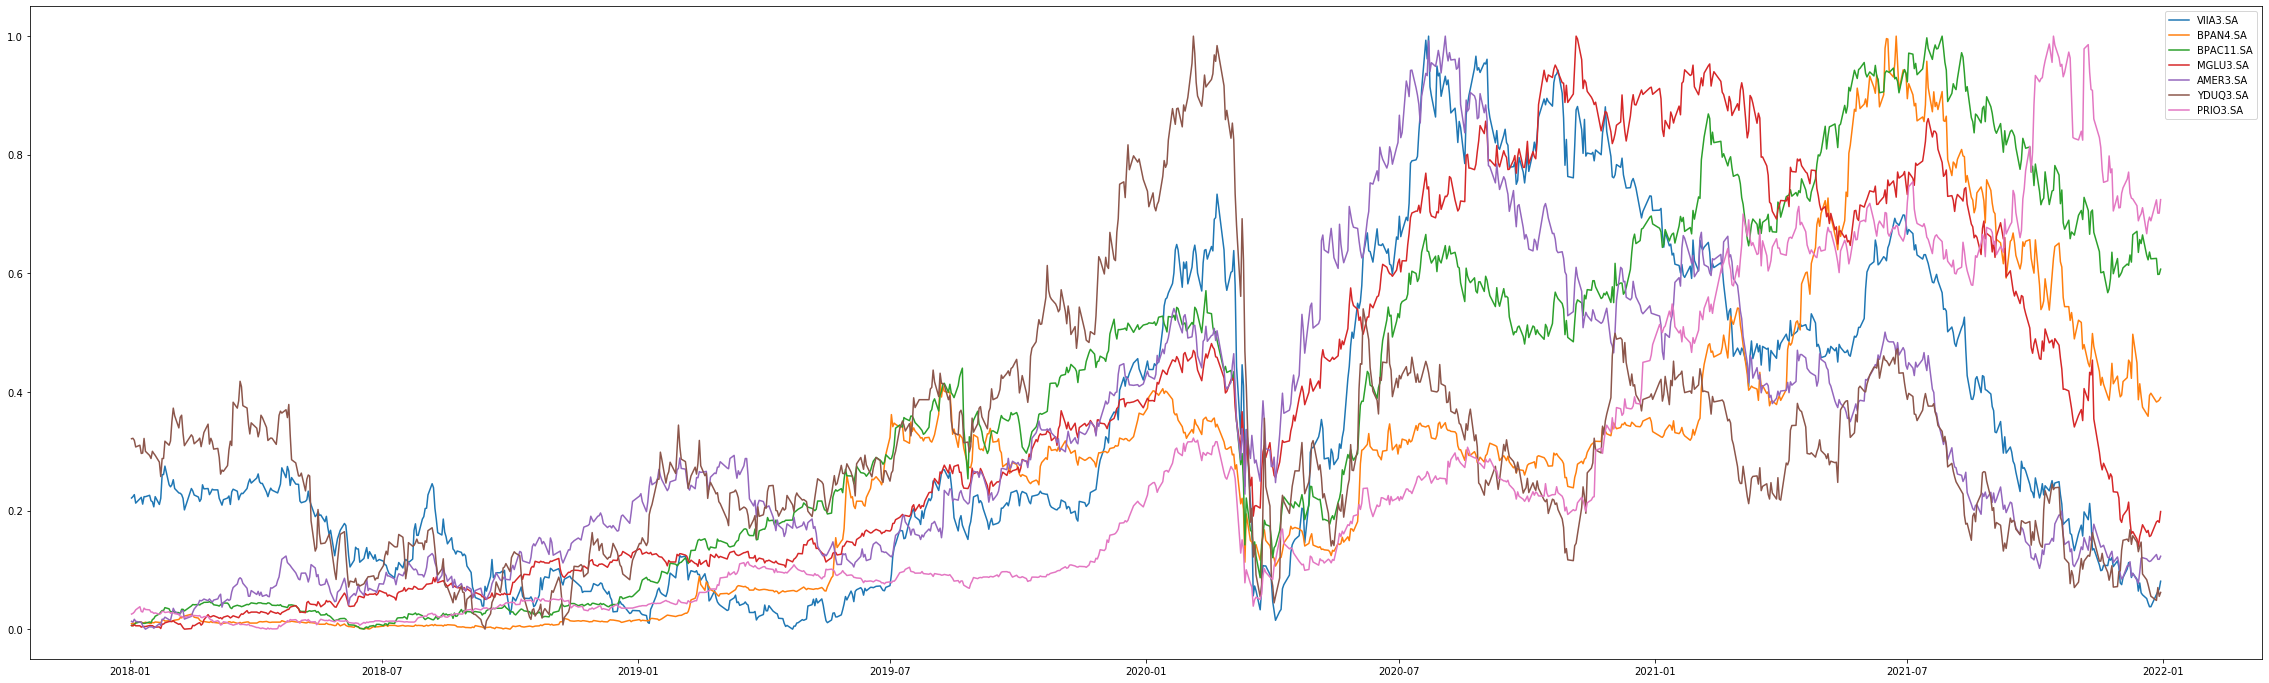

In [ ]:
for i in range(0,len(best_10_sharpe)):
  if i == 0:
    best_10 = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})
  else:
    best_10[str(best_10_sharpe.iloc[i])] = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})

for column in best_10.columns:
  best_10[column] = (best_10[column]-min(best_10[column])) /(max(best_10[column])-min(best_10[column]))

rcParams['figure.figsize'] = 40,12
for i in range(0,len(best_10.columns)):
  plt.plot(best_10.iloc[:,i],label=best_10.columns[i])
  plt.legend()

[*********************100%***********************]  1 of 1 completed


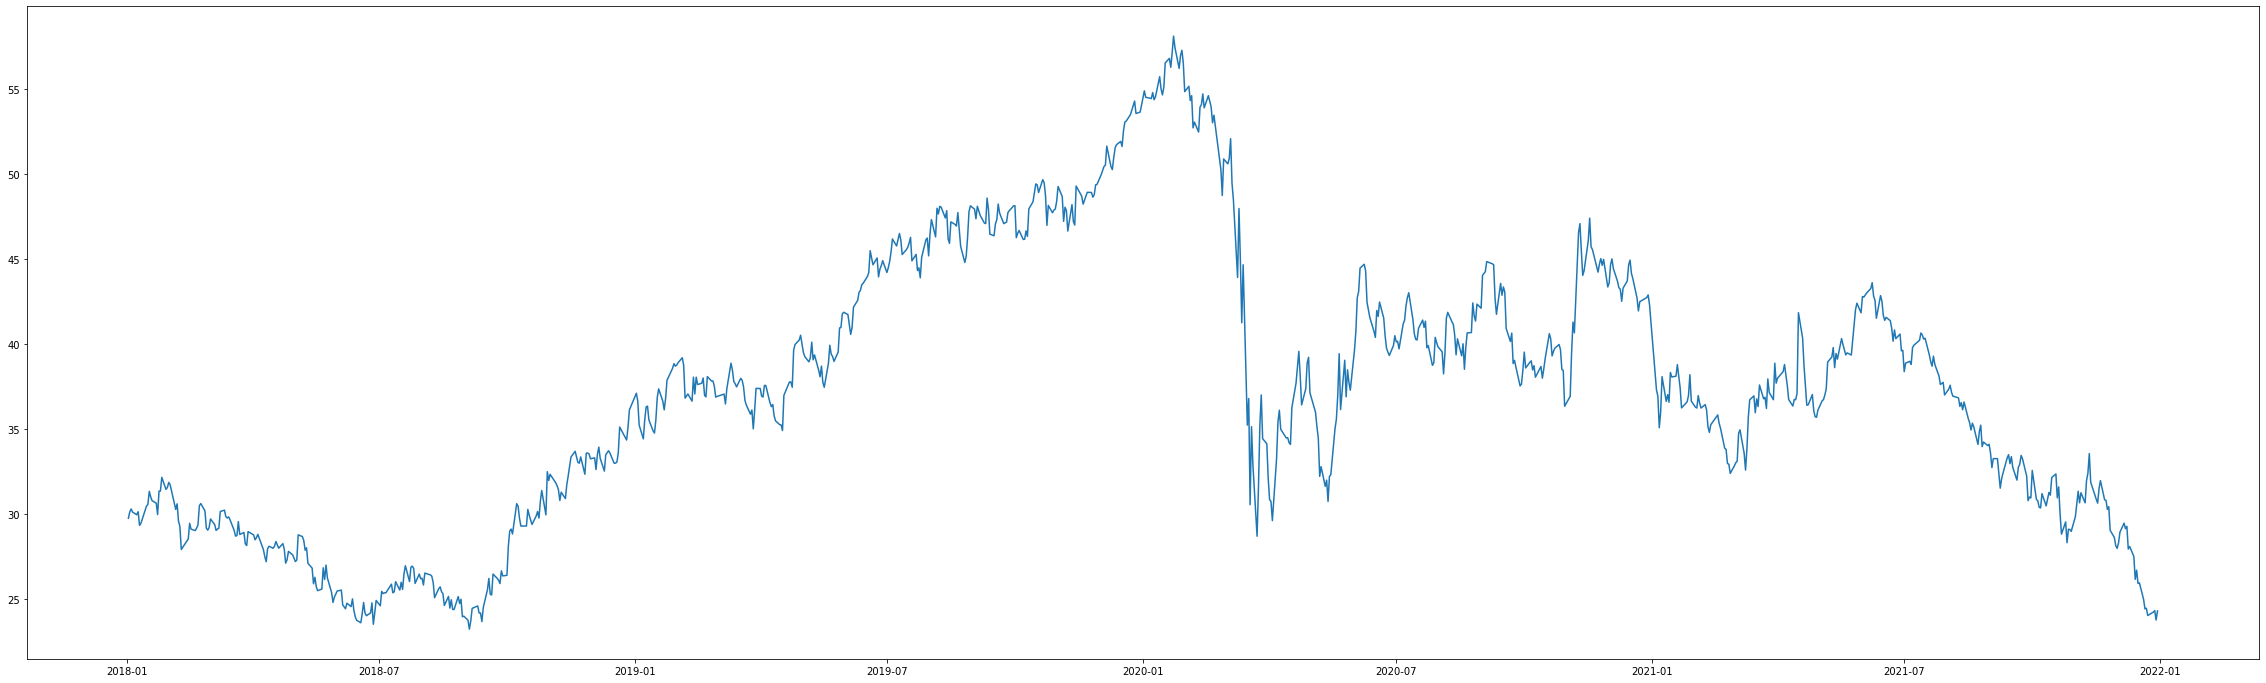

In [ ]:
plt.plot(pd.DataFrame(yf.download('LREN3.SA', start = '2018-01-01', end = '2021-12-31')['Adj Close']))

In [ ]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912 entries, 0 to 1775
Data columns (total 28 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   Data                                                            12912 non-null  object        
 1    LiqCor  consolid:sim*                                          12912 non-null  float64       
 2    LiqSec  consolid:sim*                                          12912 non-null  float64       
 3    Exig / PL  consolid:sim*                                       12912 non-null  float64       
 4    DivBr/Ebitda  de 3 meses  consolid:sim*                        12912 non-null  float64       
 5    Margem Liquida  de 3 meses  consolid:sim*                      12912 non-null  float64       
 6   ROA de 3 meses                                                  12912 non-null  float64

In [ ]:
df_indicators2 = df_indicators.copy()

In [ ]:
df_indicators = df_indicators.groupby(['Código ajustado','Indice'],dropna=False).mean().reset_index()

In [ ]:
df_indicators.groupby(['Indice']).count()

Código ajustado   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
Indice                                                                    
Ibov                 73                      73                      73   
S&P500              465                     465                     465   

         Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
Indice                                                                        
Ibov                           73                                        73   
S&P500                        465                                       465   

         Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
Indice                                                               
Ibov                                            73              73   
S&P500                                         465             465   

        ROE de 3 meses  P/L de 3 meses ajust pela infl  \
Indice                                                   
Ibov                73                              73   
S&P500             465                             465   

        Valor Mercado da empresa Em US Dollars em milhares  ...  \
Indice                                                      ...   
Ibov                                                   73   ...   
S&P500                                                465   ...   

        EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*  \
Indice                                                         
Ibov                                                   73      
S&P500                                                465      

        P/FCF Em US Dollars de 3 meses consolid:sim*  \
Indice                                                 
Ibov                                              73   
S&P500                                           465   

        Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov  \
Indice                                                                   
Ibov                                                   73                
S&P500                                                465                

        TIR média trimestral em 3 meses Em moeda orig  \
Indice                                                  
Ibov                                               73   
S&P500                                            465   

        Bollinger 90/2 Média Em moeda orig  \
Indice                                       
Ibov                                    73   
S&P500                                 465   

        Volatilidade base trimestral 3 meses Em moeda orig  \
Indice                                                       
Ibov                                                   73    
S&P500                                                465    

        VAR % base diária confiança: 95% 3 meses Em moeda orig  \
Indice                                                           
Ibov                                                   73        
S&P500                                                465        

        Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig  Sharpe Ratio  \
Indice                                                                      
Ibov                                                   73              73   
S&P500                                                465             465   

        Beta  
Indice        
Ibov      73  
S&P500   465  

[2 rows x 23 columns]

In [ ]:
df_indicators2.columns

Index(['Data', ' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       ' Data do Bal  consolid:sim*', 'Códig

##Models Applications

##UMAP testing

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [ ]:
import umap

In [ ]:
indicators_application = df_indicators.drop(['Indice','Código ajustado','Valor Mercado da empresa Em US Dollars em milhares',' Patrim Liq  Em US Dollars  em milhares  consolid:sim*'],axis='columns').replace('-',0).astype(float)
indicators_application = indicators_application.fillna(0)

In [ ]:
indicators_application = indicators_application.fillna(0)

In [ ]:
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']
indicators_data = indicators_application[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

In [ ]:
indicators_data.shape

(538, 20)

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(indicators_data)
embedding.shape 

(538, 2)

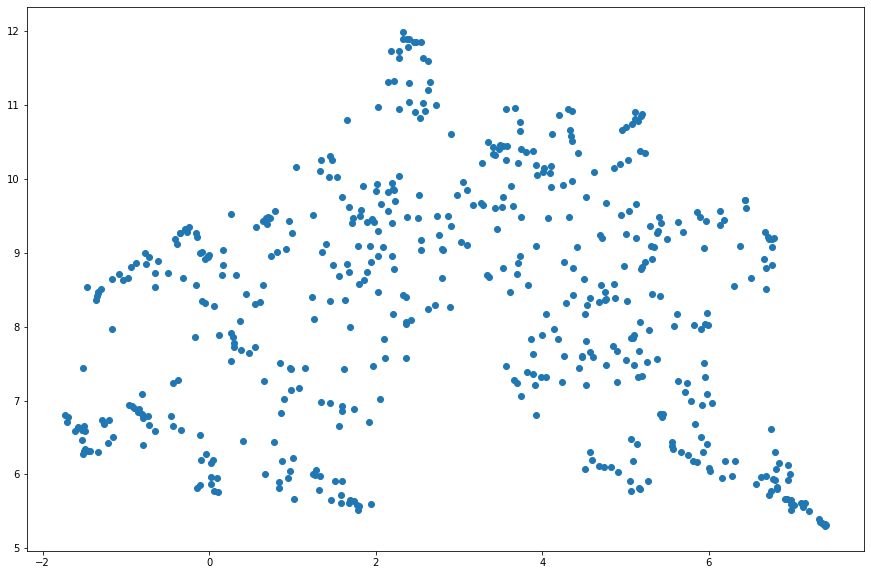

In [ ]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

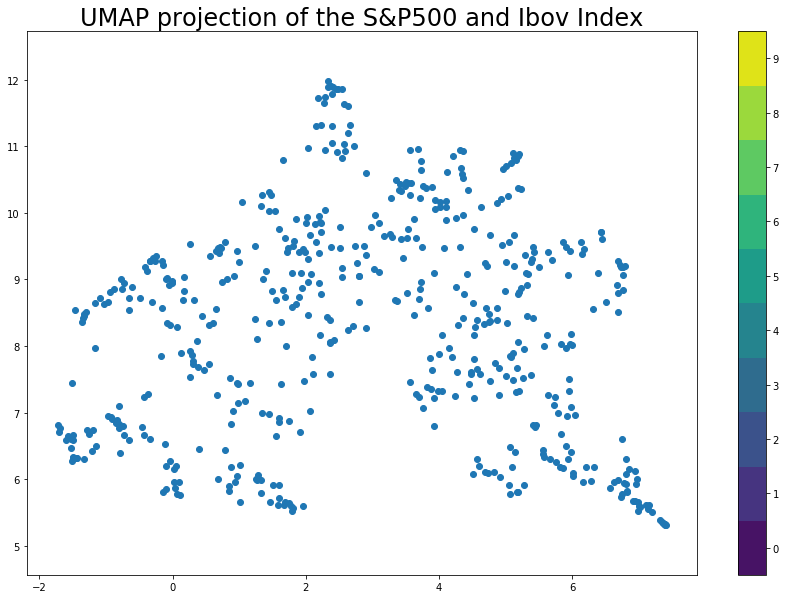

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [ ]:
data = indicators_data 

In [ ]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [ ]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [ ]:
#draw_umap(n_components=3,n_neighbors=15, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [ ]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [ ]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [ ]:
X = kmeans_input.iloc[:,[0,1]].values

In [ ]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
WCSS = []

In [ ]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

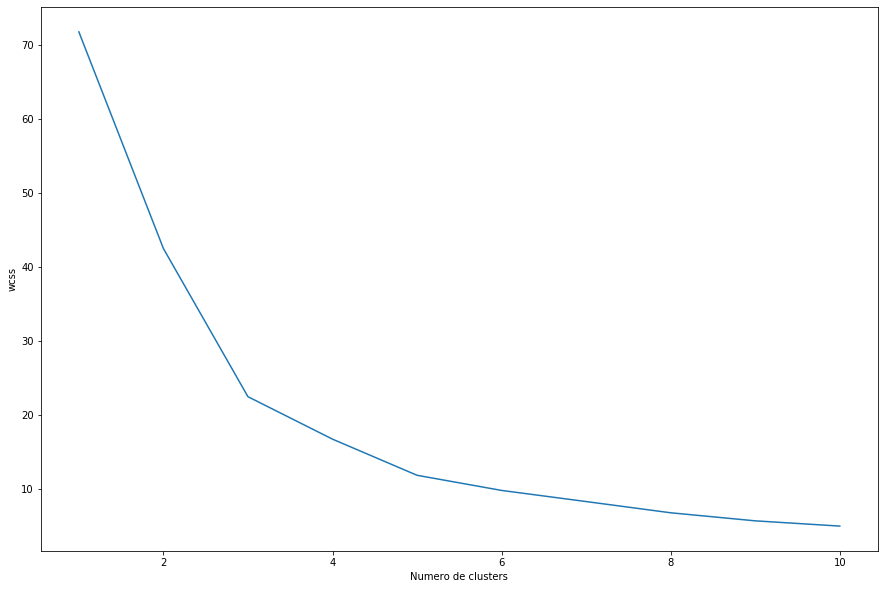

In [ ]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [ ]:
cluster_num = 4

In [ ]:
kmeans = KMeans(n_clusters=cluster_num, random_state=0)
previsoes = kmeans.fit_predict(X)

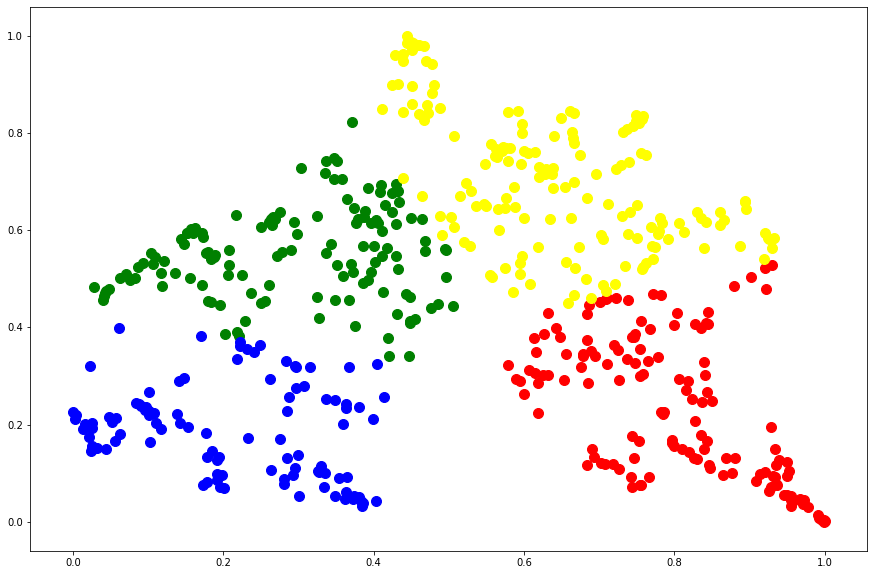

In [ ]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [ ]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [ ]:
kmeans_output

0         1    2
0    0.502971  0.627896  3.0
1    0.089981  0.239002  2.0
2    0.589846  0.294567  0.0
3    0.895033  0.643470  3.0
4    0.806492  0.615342  3.0
..        ...       ...  ...
533  0.705054  0.487834  3.0
534  0.667199  0.466732  3.0
535  0.117562  0.512080  1.0
536  0.187626  0.544459  1.0
537  0.599971  0.762906  3.0

[538 rows x 3 columns]

In [ ]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [ ]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

In [ ]:
kmeans_output.groupby('Cluster',dropna=False).count()

x    y
Cluster          
0.0      139  139
1.0      135  135
2.0      104  104
3.0      160  160

##UMAP n-neighbors x WCSS K-means

In [ ]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [ ]:
#função que plota o gráfico do WCSS pra cada n_neighbors do UMAP e adiciona os resultados numa matriz
def umap_kmeans(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);

    #k-means
    kmeans_input = pd.DataFrame(u)
    kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

    columns = ['x','y']
    for column in columns:
      kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

    X = kmeans_input.iloc[:,[0,1]].values

    WCSS = []
    for i in range (1,11):
      kmeans = KMeans(n_clusters=i,random_state=0)
      kmeans.fit(X)
      WCSS.append(kmeans.inertia_)

    rel_umap_kmeans[0].append(n_neighbors)
    rel_umap_kmeans[1].append(optimal_number_of_clusters(WCSS))

    plt.plot(range(1,11),WCSS)
    plt.xlabel('Numero de clusters')
    plt.ylabel('wcss')

In [ ]:
rel_umap_kmeans = [[],[]]

#for n in range(2,200+1):
#    umap_kmeans(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
#test = pd.DataFrame(rel_umap_kmeans).T
#test.rename(columns={0:'n_neighbors',1:'n_clusters'},inplace=True)

In [ ]:
#plt.plot(test['n_neighbors'],test['n_clusters'])
#plt.xlabel('n_neighbors')
#plt.ylabel('n_clusters')

##K-Means application for the same features used in UMAP

In [ ]:
indicators_data.shape

(538, 20)

In [ ]:
X = indicators_data#.iloc[:,[0,13]].values

In [ ]:
X

array([[0.05586858, 0.04694659, 0.31054974, ..., 0.90667282, 0.03027307,
        0.39743447],
       [0.01167887, 0.01111436, 0.29381005, ..., 0.82184782, 0.03019146,
        0.45623483],
       [0.02754744, 0.00563185, 0.31066293, ..., 0.87610645, 0.03020241,
        0.34475956],
       ...,
       [0.01963447, 0.01271715, 0.31074835, ..., 0.8553596 , 0.03029406,
        0.44184633],
       [0.0277567 , 0.01393765, 0.31135549, ..., 0.88117984, 0.03024422,
        0.41934935],
       [0.07185687, 0.04837164, 0.31080374, ..., 0.91197692, 0.03028843,
        0.35250867]])

In [ ]:
WCSS = []

In [ ]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

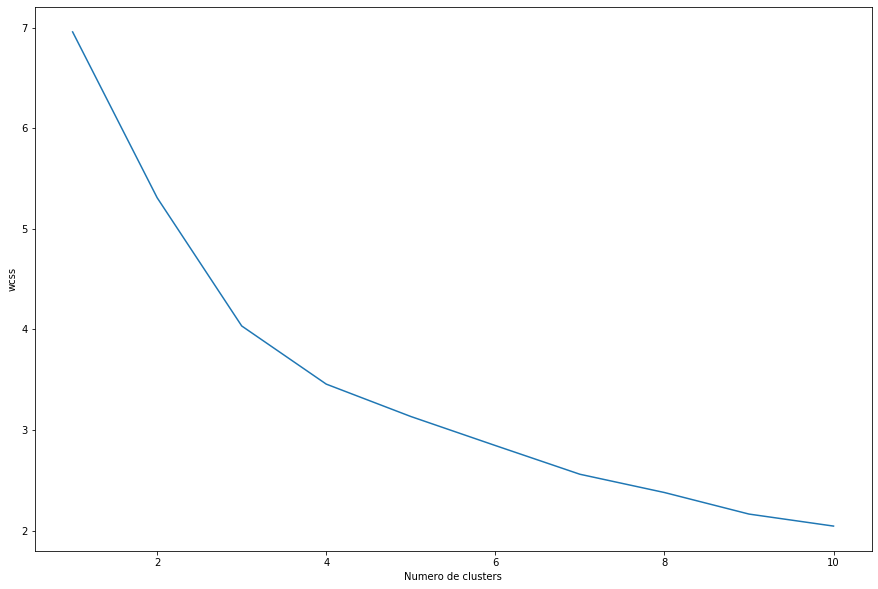

In [ ]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans.fit_predict(X)

In [ ]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [ ]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [ ]:
indicators_application['Cluster k-means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster k-means'].iloc[i] = int(cluster)

In [ ]:
kmeans_output.groupby('Cluster',dropna=False).count()

x    y
Cluster          
0.0      261  261
1.0      194  194
2.0        5    5
3.0       78   78

In [ ]:
indicators_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl', 'Price/Book ratio',
       'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',
       'Beta', 'Cluster UMAP K-Means', 'Cluster k-means'],
      dtype='object')

##PAM

In [ ]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [ ]:
X = kmeans_input.iloc[:,[0,1]].values

In [ ]:
kmedoids = KMedoids(n_clusters=cluster_num, random_state=0).fit(X)

In [ ]:
import random

In [ ]:
kmeans_input

x         y
0    0.502971  0.627896
1    0.089981  0.239002
2    0.589846  0.294567
3    0.895033  0.643470
4    0.806492  0.615342
..        ...       ...
533  0.705054  0.487834
534  0.667199  0.466732
535  0.117562  0.512080
536  0.187626  0.544459
537  0.599971  0.762906

[538 rows x 2 columns]

In [ ]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([0, 1, 1])

In [ ]:
kmedoids.cluster_centers_

array([[0.3770822 , 0.6142759 ],
       [0.8391138 , 0.1485278 ],
       [0.17670843, 0.18345043],
       [0.7378388 , 0.5918766 ]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

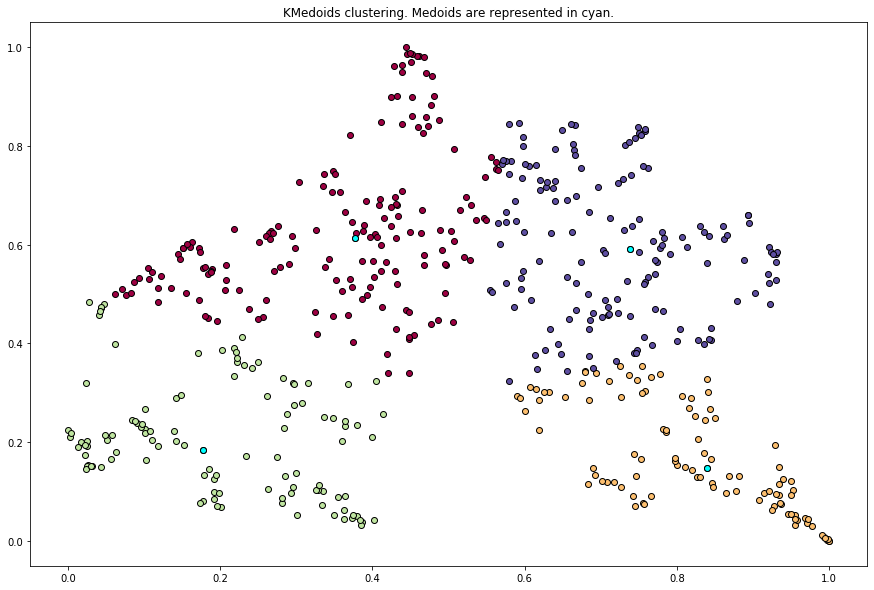

In [ ]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [ ]:
indicators_application['Cluster PAM'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmedoids.labels_[i])
  indicators_application['Cluster PAM'].iloc[i] = int(cluster)

##Hierarquical

In [ ]:
Y = kmeans_input
Y

x         y
0    0.502971  0.627896
1    0.089981  0.239002
2    0.589846  0.294567
3    0.895033  0.643470
4    0.806492  0.615342
..        ...       ...
533  0.705054  0.487834
534  0.667199  0.466732
535  0.117562  0.512080
536  0.187626  0.544459
537  0.599971  0.762906

[538 rows x 2 columns]

<Figure size 21600x21600 with 0 Axes>

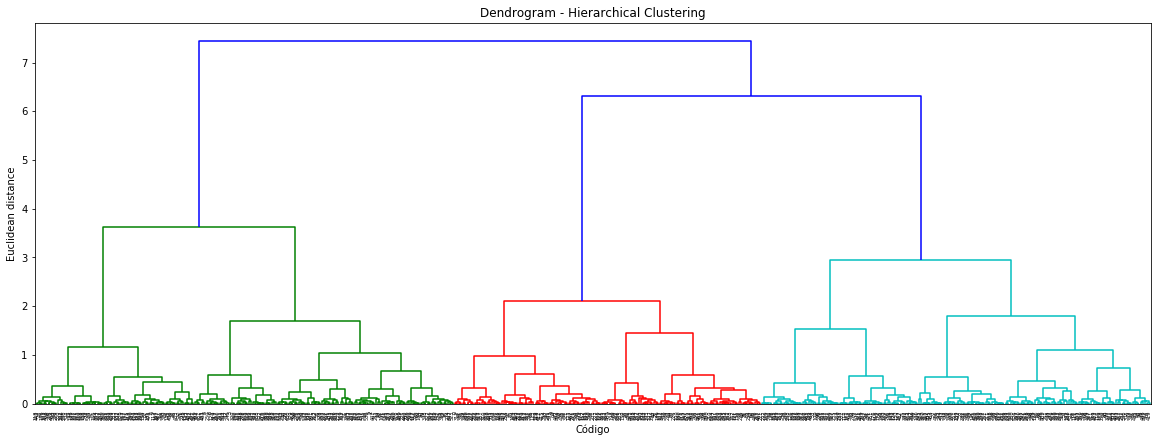

<Figure size 21600x21600 with 0 Axes>

In [ ]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

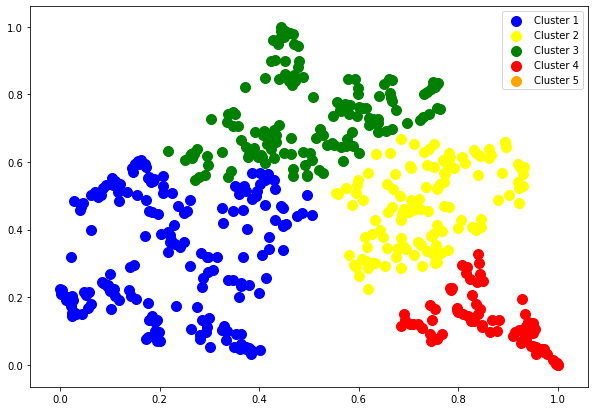

In [ ]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(indicators[hierarquical.labels_ == 3, 0], indicators[hierarquical.labels_ == 3, 1], s = 100, c = 'red', label = 'Cluster 4')
plt.scatter(indicators[hierarquical.labels_ == 4, 0], indicators[hierarquical.labels_ == 4, 1], s = 100, c = 'orange', label = 'Cluster 5')
plt.legend()
plt.show()

In [ ]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [ ]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [ ]:
indicators_application['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application['Cluster Hierarquical'].iloc[i] = int(cluster)

## Consolidação

In [ ]:
df_indicators.columns

Index(['Código ajustado', 'Indice', ' LiqCor  consolid:sim*',
       ' LiqSec  consolid:sim*', ' Exig / PL  consolid:sim*',
       ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',


In [ ]:
len(indicators_application) - len(df_indicators)

0

In [ ]:
indicators_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl', 'Price/Book ratio',
       'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',
       'Beta', 'Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM',
       'Cluster Hierarquical'],
      dtype='object')

In [ ]:
df_indicators['Cluster UMAP K-Means'] = ''
df_indicators['Cluster k-means'] = ''
df_indicators['Cluster PAM'] = ''
df_indicators['Cluster Hierarquical'] = ''

In [ ]:
models = ['Cluster UMAP K-Means','Cluster k-means','Cluster PAM','Cluster Hierarquical'] 
for model in models:
  df_indicators[model] = ''
  for i in range(0,len(indicators_application)):
    cluster = int(indicators_application[model].iloc[i])
    df_indicators[model].iloc[i] = int(cluster)

In [ ]:
df_indicators

Código ajustado  Indice   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
0                 A  S&P500                0.055869                0.046947   
1               AAL  S&P500                0.011679                0.011114   
2               AAP  S&P500                0.027547                0.005632   
3              AAPL  S&P500                0.025580                0.025956   
4              ABBV  S&P500                0.026537                0.025087   
..              ...     ...                     ...                     ...   
533             YUM  S&P500                0.022740                0.023732   
534             ZBH  S&P500                0.038185                0.020369   
535            ZBRA  S&P500                0.019634                0.012717   
536            ZION  S&P500                0.027757                0.013938   
537             ZTS  S&P500                0.071857                0.048372   

      Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
0                     0.310550                                  0.117198   
1                     0.293810                                  0.117209   
2                     0.310663                                  0.117199   
3                     0.310726                                  0.117197   
4                     0.310779                                  0.117201   
..                         ...                                       ...   
533                   0.310297                                  0.117205   
534                   0.310574                                  0.117205   
535                   0.310748                                  0.117202   
536                   0.311355                                  0.117206   
537                   0.310804                                  0.117200   

      Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
0                                      0.917721        0.554865   
1                                      0.917259        0.528572   
2                                      0.917610        0.547220   
3                                      0.917933        0.585746   
4                                      0.917877        0.555553   
..                                          ...             ...   
533                                    0.917920        0.606310   
534                                    0.917606        0.536333   
535                                    0.917622        0.551170   
536                                    0.917390        0.533257   
537                                    0.917936        0.569646   

     ROE de 3 meses  P/L de 3 meses ajust pela infl  ...  \
0          0.328195                        0.032411  ...   
1          0.361141                        0.032373  ...   
2          0.328209                        0.032399  ...   
3          0.332227                        0.032381  ...   
4          0.339209                        0.032392  ...   
..              ...                             ...  ...   
533        0.381855                        0.032394  ...   
534        0.327389                        0.032373  ...   
535        0.328281                        0.032429  ...   
536        0.327760                        0.032381  ...   
537        0.331060                        0.032436  ...   

     Bollinger 90/2 Média Em moeda orig  \
0                              0.014314   
1                              0.006059   
2                              0.028503   
3                              0.011196   
4                              0.014273   
..                                  ...   
533                            0.016089   
534                            0.023020   
535                            0.041604   
536                            0.007745   
537                            0.019830   

     Volatilidade base trimestral 3 meses Em moeda orig  \
0                                       

In [ ]:
#df_indicators.loc['Cluster UMAP K-Means'] = indicators_application['Cluster UMAP K-Means'].astype(float)
#df_indicators.loc['Cluster k-means'] = indicators_application['Cluster k-means'].astype(float)
#df_indicators.loc['Cluster PAM'] = indicators_application['Cluster PAM'].astype(float)
#df_indicators.loc['Cluster Hierarquical'] = indicators_application['Cluster Hierarquical'].astype(float)

In [ ]:
df_indicators_dtref = df_indicators.copy()

In [ ]:
df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']] = df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']].astype(int)

In [ ]:
df_indicators_dtref

Código ajustado  Indice   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
0                 A  S&P500                0.055869                0.046947   
1               AAL  S&P500                0.011679                0.011114   
2               AAP  S&P500                0.027547                0.005632   
3              AAPL  S&P500                0.025580                0.025956   
4              ABBV  S&P500                0.026537                0.025087   
..              ...     ...                     ...                     ...   
533             YUM  S&P500                0.022740                0.023732   
534             ZBH  S&P500                0.038185                0.020369   
535            ZBRA  S&P500                0.019634                0.012717   
536            ZION  S&P500                0.027757                0.013938   
537             ZTS  S&P500                0.071857                0.048372   

      Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
0                     0.310550                                  0.117198   
1                     0.293810                                  0.117209   
2                     0.310663                                  0.117199   
3                     0.310726                                  0.117197   
4                     0.310779                                  0.117201   
..                         ...                                       ...   
533                   0.310297                                  0.117205   
534                   0.310574                                  0.117205   
535                   0.310748                                  0.117202   
536                   0.311355                                  0.117206   
537                   0.310804                                  0.117200   

      Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
0                                      0.917721        0.554865   
1                                      0.917259        0.528572   
2                                      0.917610        0.547220   
3                                      0.917933        0.585746   
4                                      0.917877        0.555553   
..                                          ...             ...   
533                                    0.917920        0.606310   
534                                    0.917606        0.536333   
535                                    0.917622        0.551170   
536                                    0.917390        0.533257   
537                                    0.917936        0.569646   

     ROE de 3 meses  P/L de 3 meses ajust pela infl  ...  \
0          0.328195                        0.032411  ...   
1          0.361141                        0.032373  ...   
2          0.328209                        0.032399  ...   
3          0.332227                        0.032381  ...   
4          0.339209                        0.032392  ...   
..              ...                             ...  ...   
533        0.381855                        0.032394  ...   
534        0.327389                        0.032373  ...   
535        0.328281                        0.032429  ...   
536        0.327760                        0.032381  ...   
537        0.331060                        0.032436  ...   

     Bollinger 90/2 Média Em moeda orig  \
0                              0.014314   
1                              0.006059   
2                              0.028503   
3                              0.011196   
4                              0.014273   
..                                  ...   
533                            0.016089   
534                            0.023020   
535                            0.041604   
536                            0.007745   
537                            0.019830   

     Volatilidade base trimestral 3 meses Em moeda orig  \
0                                       

# Ts Features

##Reading data

In [ ]:
df_ibov_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_Ibov.xlsx')
df_ibov_features['Indice'] = 'Ibov'

df_sp500_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_SP500.xlsx').rename(columns={'unique_id':'Código'})
df_sp500_features['Indice'] = 'S&P500'

df_indicators_features = pd.concat([df_sp500_features,df_ibov_features]).drop('Unnamed: 0',axis='columns')

In [ ]:
df_indicators_features

Código     hurst  series_length  unitroot_pp  unitroot_kpss      hw_alpha  \
0       A  0.409325             23   -28.048995       0.086791  1.490140e-08   
1     AAL  0.444551             23   -18.305093       0.043385  1.490224e-08   
2     AAP  0.456325             23   -27.906333       0.143533  1.490116e-08   
3    AAPL  0.379082             23   -26.430065       0.158570  1.490272e-08   
4    ABBV  0.376635             23   -26.615092       0.110332  1.490116e-08   
..    ...       ...            ...          ...            ...           ...   
69  VALE3  0.334208             23   -33.611740       0.321794  1.490116e-08   
70  VIIA3  0.376266             23   -27.809848       0.107609  1.490168e-08   
71  VIVT3  0.490203             23    -7.253861       0.327952  7.595821e-01   
72  WEGE3  0.380091             23   -23.865743       0.071488  1.490182e-08   
73  YDUQ3  0.528298             23   -22.126242       0.108805  1.490139e-08   

         hw_beta      hw_gamma  stability  nperiods  ...  crossing_points  \
0   1.489508e-08  2.260365e-13   0.000523         1  ...               15   
1   1.489431e-08  1.421007e-12   0.010302         1  ...                8   
2   2.910258e-10  0.000000e+00   0.005369         1  ...               16   
3   2.875035e-10  1.639721e-12   0.000258         1  ...               16   
4   1.489613e-08  0.000000e+00   0.007156         1  ...               15   
..           ...           ...        ...       ...  ...              ...   
69  2.825846e-10  0.000000e+00   0.004601         1  ...               15   
70  2.915011e-10  5.650508e-13   0.002836         1  ...               16   
71  7.595821e-01  0.000000e+00   0.007792         1  ...               13   
72  2.904799e-10  6.772401e-13   0.004167         1  ...               13   
73  2.765365e-10  2.359056e-13   0.006843         1  ...               15   

    arch_lm    x_acf1   x_acf10  diff1_acf1  diff1_acf10  diff2_acf1  \
0         1 -0.367334  0.783027   -0.631981     1.194119   -0.729109   
1         1  0.101278  1.272607   -0.217840     0.646837   -0.495520   
2         1 -0.434876  0.929963   -0.605135     1.124590   -0.669117   
3         1 -0.279101  0.555910   -0.440556     0.937416   -0.570956   
4         1 -0.414487  1.540309   -0.558107     1.857736   -0.597467   
..      ...       ...       ...         ...          ...         ...   
69        1 -0.347456  0.261871   -0.535398     0.723522   -0.658143   
70        1 -0.430207  0.927184   -0.596678     1.274089   -0.644703   
71        1  0.110174  0.064405   -0.026276     0.088235   -0.429111   
72        1 -0.220589  0.581730   -0.447667     0.831758   -0.612087   
73        1 -0.116265  0.408519   -0.541177     0.856168   -0.708203   

    diff2_acf10  seas_acf1  Indice  
0      1.503309  -0.233997  S&P500  
1      0.652494   0.037392  S&P500  
2      1.210058  -0.333618  S&P500  
3      1.277200  -0.240945  S&P500  
4      1.853404  -0.348933  S&P500  
..          ...        ...     ...  
69     1.196353  -0.163097    Ibov  
70     1.409231  -0.326718    Ibov  
71     0.347862   0.044202    Ibov  
72     1.195074  -0.226041    Ibov  
73     1.358515  -0.047637    Ibov  

[539 rows x 44 columns]

In [ ]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice'],
      dtype='object')

##EDA

In [ ]:
df_indicators_features.isnull().sum()

Código               0
hurst                0
series_length        0
unitroot_pp          0
unitroot_kpss        0
hw_alpha             0
hw_beta              0
hw_gamma             0
stability            0
nperiods             0
seasonal_period      0
trend                0
spike                0
linearity            0
curvature            0
e_acf1               0
e_acf10              0
seasonal_strength    0
peak                 0
trough               0
x_pacf5              0
diff1x_pacf5         0
diff2x_pacf5         0
seas_pacf            0
nonlinearity         0
lumpiness            0
alpha                0
beta                 0
arch_acf             0
garch_acf            0
arch_r2              0
garch_r2             0
flat_spots           0
entropy              0
crossing_points      0
arch_lm              0
x_acf1               0
x_acf10              0
diff1_acf1           0
diff1_acf10          0
diff2_acf1           0
diff2_acf10          0
seas_acf1            0
Indice     

In [ ]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators_features['Código ajustado']=df_indicators_features['Código']
df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado'] = df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado']+str('.SA')

In [ ]:
df_indicators_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 73
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código             539 non-null    object 
 1   hurst              539 non-null    float64
 2   series_length      539 non-null    int64  
 3   unitroot_pp        539 non-null    float64
 4   unitroot_kpss      539 non-null    float64
 5   hw_alpha           539 non-null    float64
 6   hw_beta            539 non-null    float64
 7   hw_gamma           539 non-null    float64
 8   stability          539 non-null    float64
 9   nperiods           539 non-null    int64  
 10  seasonal_period    539 non-null    int64  
 11  trend              539 non-null    float64
 12  spike              539 non-null    float64
 13  linearity          539 non-null    float64
 14  curvature          539 non-null    float64
 15  e_acf1             539 non-null    float64
 16  e_acf10            539 non-

In [ ]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [ ]:
#normaliza as colunas de formato float
columns = ['hurst', 'series_length', 'unitroot_pp',
       'unitroot_kpss', 'hw_alpha', 'hw_beta', 'hw_gamma', 'stability',
       'nperiods', 'seasonal_period', 'trend', 'spike', 'linearity',
       'curvature', 'e_acf1', 'e_acf10', 'seasonal_strength', 'peak', 'trough',
       'x_pacf5', 'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators_features[column] = (df_indicators_features[column]-min(df_indicators_features[column].dropna())) /(max(df_indicators_features[column].dropna())-min(df_indicators_features[column].dropna()))

##Models Applications

##UMAP testing

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [ ]:
import umap

In [ ]:
indicators_application_features = df_indicators_features.drop(['Código','Indice','Código ajustado'],axis='columns').replace('-',0).astype(float)
indicators_application_features = indicators_application_features.fillna(0)

In [ ]:
indicators_application_features = indicators_application_features.fillna(0)

In [ ]:
indicators_data_features = indicators_application_features[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data_features)

In [ ]:
indicators_data_features.shape

(539, 42)

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(indicators_data_features)
embedding.shape 

(539, 2)

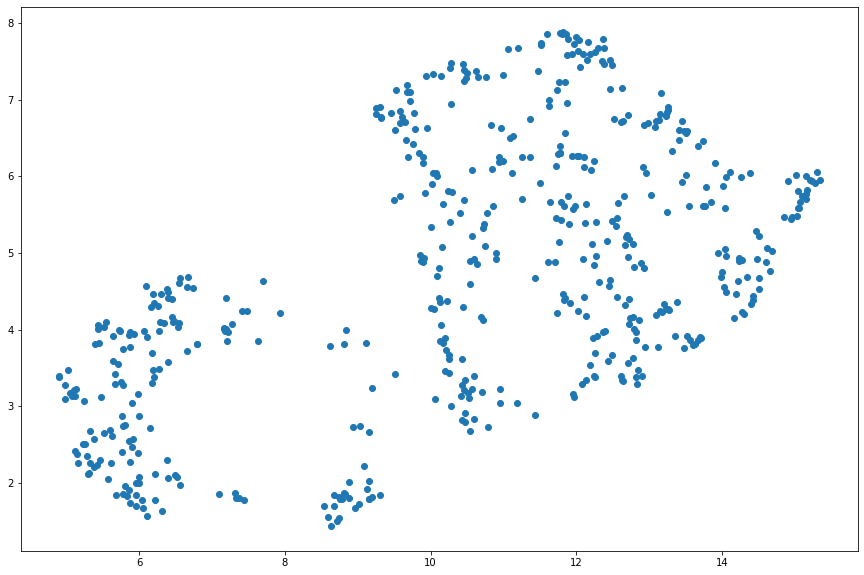

In [ ]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

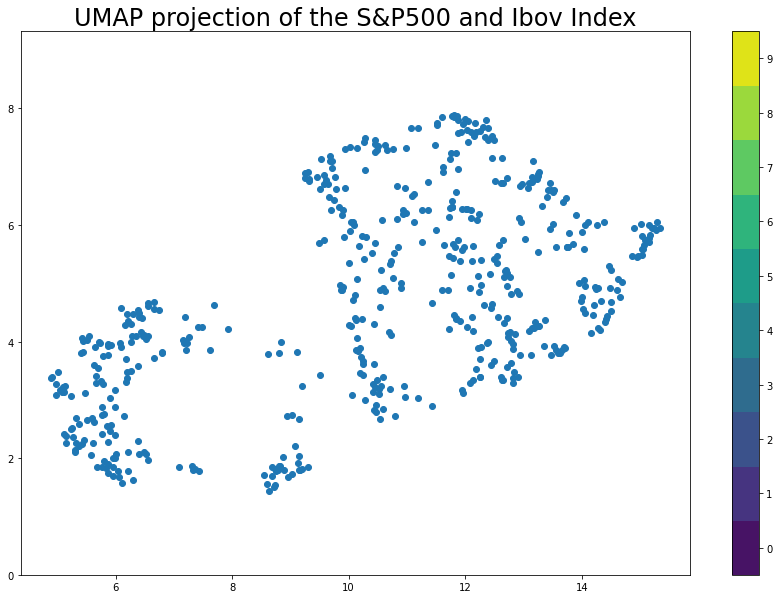

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [ ]:
data = indicators_data_features 

In [ ]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [ ]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [ ]:
len(indicators_data_features)

539

In [ ]:
#draw_umap(n_components=3,n_neighbors=200, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [ ]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [ ]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [ ]:
X = kmeans_input.iloc[:,[0,1]].values

In [ ]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
WCSS = []

In [ ]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

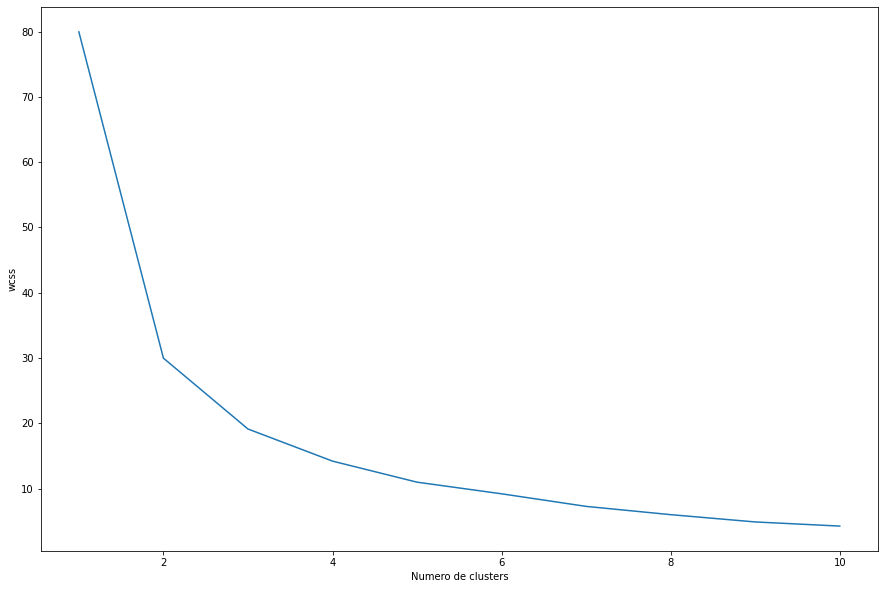

In [ ]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans.fit_predict(X)

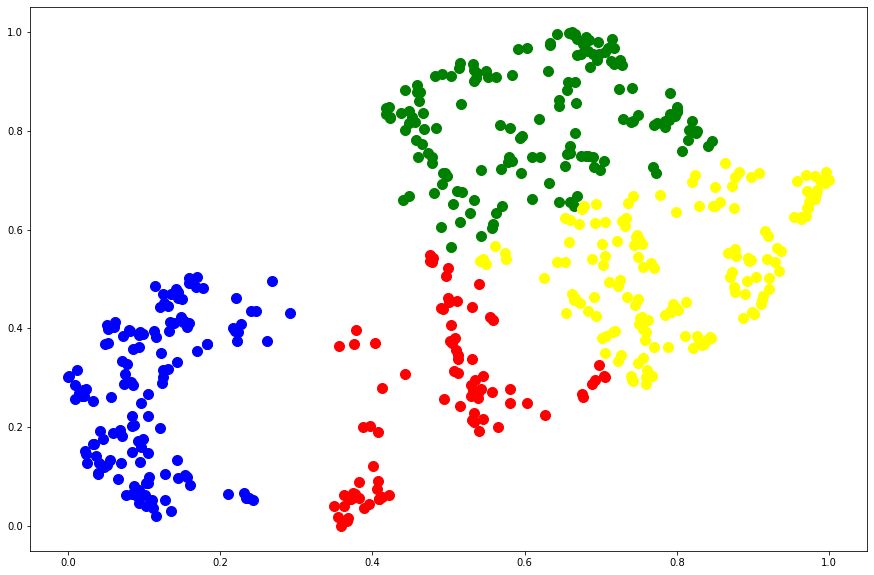

In [ ]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [ ]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [ ]:
kmeans_output

0         1    2
0    0.080722  0.394381  2.0
1    0.515086  0.242791  0.0
2    0.182006  0.368946  2.0
3    0.819909  0.695829  3.0
4    0.570777  0.648646  1.0
..        ...       ...  ...
534  0.374473  0.066509  0.0
535  0.826440  0.800232  1.0
536  0.365852  0.009872  0.0
537  0.126758  0.104927  2.0
538  0.748600  0.330417  3.0

[539 rows x 3 columns]

In [ ]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [ ]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application_features['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application_features['Cluster UMAP K-Means'].iloc[i] = int(cluster)

In [ ]:
kmeans_output.groupby('Cluster',dropna=False).count()

x    y
Cluster          
0.0       85   85
1.0      157  157
2.0      139  139
3.0      158  158

##PAM

In [ ]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [ ]:
X = kmeans_input.iloc[:,[0,1]].values

In [ ]:
kmedoids = KMedoids(n_clusters=4, random_state=0).fit(X)

In [ ]:
import random

In [ ]:
kmeans_input

x         y
0    0.080722  0.394381
1    0.515086  0.242791
2    0.182006  0.368946
3    0.819909  0.695829
4    0.570777  0.648646
..        ...       ...
534  0.374473  0.066509
535  0.826440  0.800232
536  0.365852  0.009872
537  0.126758  0.104927
538  0.748600  0.330417

[539 rows x 2 columns]

In [ ]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([3, 1, 1])

In [ ]:
kmedoids.cluster_centers_

array([[0.7510946 , 0.42025954],
       [0.6593353 , 0.7700526 ],
       [0.12675768, 0.10492703],
       [0.1321824 , 0.39542547]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

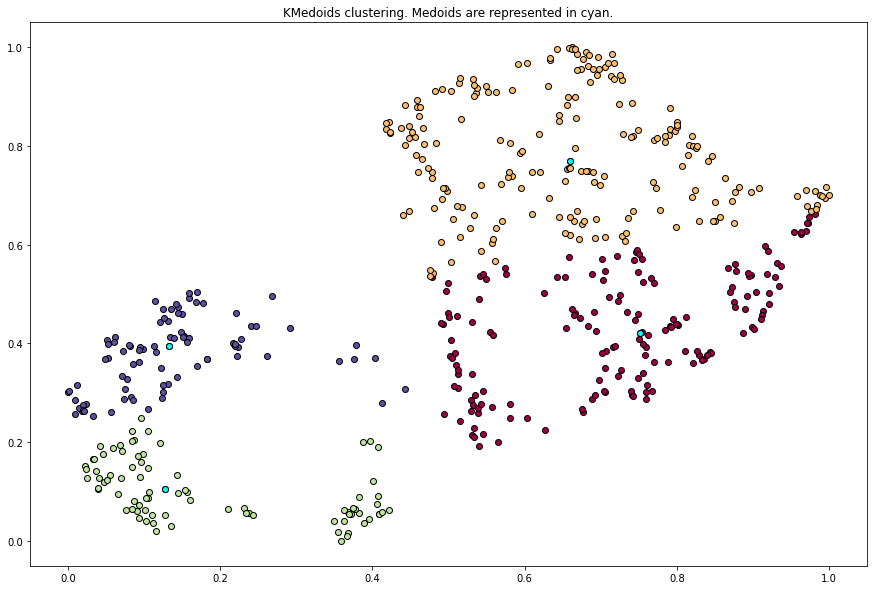

In [ ]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [ ]:
indicators_application_features['Cluster PAM'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmedoids.labels_[i])
  indicators_application_features['Cluster PAM'].iloc[i] = int(cluster)

##Hierarquical

In [ ]:
Y = kmeans_input
Y

x         y
0    0.080722  0.394381
1    0.515086  0.242791
2    0.182006  0.368946
3    0.819909  0.695829
4    0.570777  0.648646
..        ...       ...
534  0.374473  0.066509
535  0.826440  0.800232
536  0.365852  0.009872
537  0.126758  0.104927
538  0.748600  0.330417

[539 rows x 2 columns]

<Figure size 21600x21600 with 0 Axes>

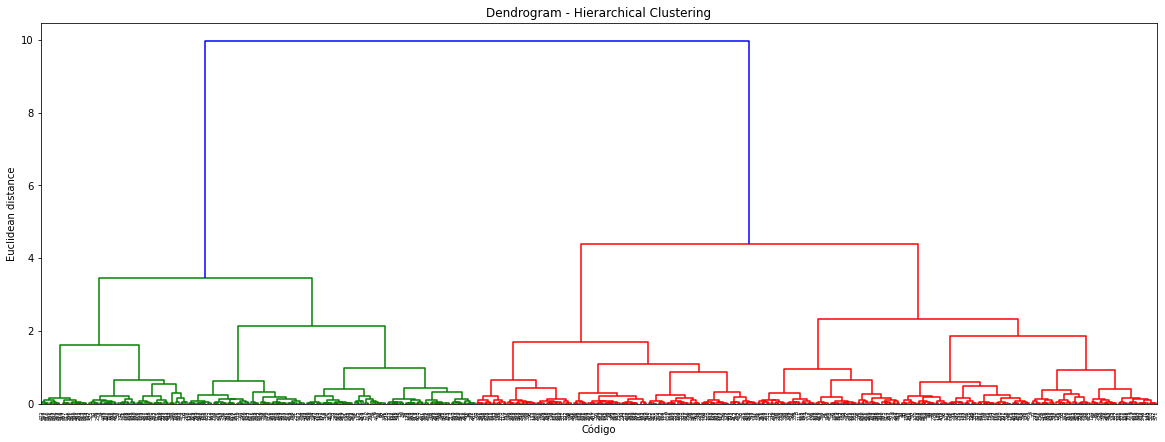

<Figure size 21600x21600 with 0 Axes>

In [ ]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

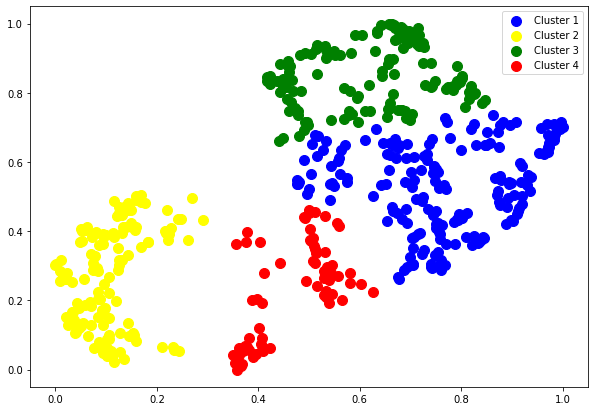

In [ ]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(indicators[hierarquical.labels_ == 3, 0], indicators[hierarquical.labels_ == 3, 1], s = 100, c = 'red', label = 'Cluster 4')
plt.legend()
plt.show()

In [ ]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [ ]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [ ]:
indicators_application_features['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application_features['Cluster Hierarquical'].iloc[i] = int(cluster)

## Consolidação

In [ ]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [ ]:
len(indicators_application_features) - len(df_indicators_features)

0

In [ ]:
df_indicators_features['Cluster UMAP K-Means'] = indicators_application_features['Cluster UMAP K-Means'].astype(float)
df_indicators_features['Cluster PAM'] = indicators_application_features['Cluster PAM'].astype(float)
df_indicators_features['Cluster Hierarquical'] = indicators_application_features['Cluster Hierarquical'].astype(float)

In [ ]:
df_indicators_features

Código     hurst  series_length  unitroot_pp  unitroot_kpss      hw_alpha  \
0       A  0.774800            NaN     0.300999       0.259242  1.865980e-08   
1     AAL  0.841478            NaN     0.543824       0.129590  1.866086e-08   
2     AAP  0.863766            NaN     0.304554       0.428728  1.865950e-08   
3    AAPL  0.717553            NaN     0.341343       0.473644  1.866145e-08   
4    ABBV  0.712921            NaN     0.336732       0.329560  1.865950e-08   
..    ...       ...            ...          ...            ...           ...   
69  VALE3  0.632613            NaN     0.162371       0.961189  1.865950e-08   
70  VIIA3  0.712224            NaN     0.306958       0.321426  1.866016e-08   
71  VIVT3  0.927891            NaN     0.819228       0.979584  9.511625e-01   
72  WEGE3  0.719464            NaN     0.405248       0.213533  1.866033e-08   
73  YDUQ3  1.000000            NaN     0.448598       0.324997  1.865979e-08   

         hw_beta  hw_gamma  stability  nperiods  ...  diff1_acf1  diff1_acf10  \
0   1.865189e-08  0.033430   0.007192       NaN  ...    0.227620     0.313367   
1   1.865092e-08  0.210160   0.141644       NaN  ...    0.596333     0.169746   
2   3.644278e-10  0.000000   0.073828       NaN  ...    0.251521     0.295120   
3   3.600171e-10  0.242507   0.003550       NaN  ...    0.398048     0.246001   
4   1.865320e-08  0.000000   0.098391       NaN  ...    0.293391     0.487516   
..           ...       ...        ...       ...  ...         ...          ...   
69  3.538576e-10  0.000000   0.063268       NaN  ...    0.313608     0.189870   
70  3.650230e-10  0.083568   0.038999       NaN  ...    0.259050     0.334353   
71  9.511625e-01  0.000000   0.107137       NaN  ...    0.766885     0.023155   
72  3.637442e-10  0.100161   0.057300       NaN  ...    0.391717     0.218274   
73  3.462841e-10  0.034889   0.094089       NaN  ...    0.308464     0.224680   

    diff2_acf1  diff2_acf10  seas_acf1  Indice  Código ajustado  \
0     0.218110     0.328394   0.449998  S&P500                A   
1     0.466520     0.142536   0.777134  S&P500              AAL   
2     0.281908     0.264334   0.329914  S&P500              AAP   
3     0.386299     0.279001   0.441623  S&P500             AAPL   
4     0.358105     0.404872   0.311452  S&P500             ABBV   
..         ...          ...        ...     ...              ...   
69    0.293579     0.261340   0.535462    Ibov         VALE3.SA   
70    0.307872     0.307843   0.338231    Ibov         VIIA3.SA   
71    0.537143     0.075990   0.785343    Ibov         VIVT3.SA   
72    0.342557     0.261061   0.459589    Ibov         WEGE3.SA   
73    0.240343     0.296764   0.674639    Ibov         YDUQ3.SA   

    Cluster UMAP K-Means  Cluster PAM  Cluster Hierarquical  
0                    2.0          3.0                   1.0  
1                    0.0          0.0                   3.0  
2                    2.0          3.0                   1.0  
3                    3.0          1.0                   0.0  
4                    1.0          1.0                   0.0  
..                   ...          ...                   ...  
69                   0.0          2.0                   3.0  
70                   1.0          1.0                   2.0  
71                   0.0          2.0                   3.0  
72                   2.0          2.0                   1.0  
73                   3.0          0.0                   0.0  

[539 rows x 48 columns]

In [ ]:
df_indicators_features = pd.merge(df_indicators_features,df_indicators_dtref[['Código ajustado','Sharpe Ratio']],how='inner',on='Código ajustado')

In [ ]:
df_indicators2 = df_indicators.copy()
df_indicators2 = df_indicators2.rename(columns={'Código ajustado':'Código'})
df_indicators2

Código  Indice   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
0        A  S&P500                0.039062                0.032837   
1      AAL  S&P500                0.008165                0.007774   
2      AAP  S&P500                0.019260                0.003939   
3     AAPL  S&P500                0.017885                0.018155   
4     ABBV  S&P500                0.018554                0.017547   
..     ...     ...                     ...                     ...   
534    YUM  S&P500                0.015899                0.016599   
535    ZBH  S&P500                0.026698                0.014247   
536   ZBRA  S&P500                0.013728                0.008895   
537   ZION  S&P500                0.019407                0.009749   
538    ZTS  S&P500                0.050240                0.033834   

      Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
0                     0.310550                                  0.117198   
1                     0.293810                                  0.117209   
2                     0.310663                                  0.117199   
3                     0.310726                                  0.117197   
4                     0.310779                                  0.117201   
..                         ...                                       ...   
534                   0.310297                                  0.117205   
535                   0.310574                                  0.117205   
536                   0.310748                                  0.117202   
537                   0.311355                                  0.117206   
538                   0.310804                                  0.117200   

      Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
0                                      0.917721        0.548755   
1                                      0.917259        0.522751   
2                                      0.917610        0.541194   
3                                      0.917933        0.579296   
4                                      0.917877        0.549435   
..                                          ...             ...   
534                                    0.917920        0.599633   
535                                    0.917606        0.530427   
536                                    0.917622        0.545100   
537                                    0.917390        0.527385   
538                                    0.917936        0.563373   

     ROE de 3 meses  P/L de 3 meses ajust pela infl  ...  \
0          0.328195                        0.032411  ...   
1          0.361141                        0.032373  ...   
2          0.328209                        0.032399  ...   
3          0.332227                        0.032381  ...   
4          0.339209                        0.032392  ...   
..              ...                             ...  ...   
534        0.381855                        0.032394  ...   
535        0.327389                        0.032373  ...   
536        0.328281                        0.032429  ...   
537        0.327760                        0.032381  ...   
538        0.331060                        0.032436  ...   

     Bollinger 90/2 Média Em moeda orig  \
0                              0.014314   
1                              0.006059   
2                              0.028503   
3                              0.011196   
4                              0.014273   
..                                  ...   
534                            0.016089   
535                            0.023020   
536                            0.041604   
537                            0.007745   
538                            0.019830   

     Volatilidade base trimestral 3 meses Em moeda orig  \
0                                             0.072304    
1                                             0.147551    
2                             

In [ ]:
assets_select_features = df_indicators_features.head(0)
for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
  for i in range(0,4):
    assets_select_i_features = df_indicators_features.loc[df_indicators_features[model].astype(int)==int(i)].sort_values(by='Sharpe Ratio',ascending=False)[:5]
    assets_select_i_features['Modelo'] = str(model)
    assets_select_features = assets_select_features.append([assets_select_i_features])

In [ ]:
assets_select_features

Código     hurst  series_length  unitroot_pp  unitroot_kpss  \
513   MRFG3  0.739215            NaN     0.309528       0.663553   
494   EMBR3  0.674102            NaN     0.395383       0.147284   
473   BEEF3  0.654441            NaN     0.288762       0.252306   
483   CPFE3  0.552720            NaN     0.281747       0.898176   
527   SBSP3  0.734979            NaN     0.379537       0.727361   
521   PRIO3  0.822511            NaN     0.347632       0.189708   
103     CRL  0.699342            NaN     0.313455       0.165603   
286    MPWR  0.774390            NaN     0.361695       0.241691   
201    HOLX  0.796993            NaN     0.299426       0.333798   
356     PWR  0.542425            NaN     0.240805       0.284049   
508   JBSS3  0.665540            NaN     0.395009       0.737412   
537   WEGE3  0.719464            NaN     0.405248       0.213533   
505  IGTI11  0.000000            NaN     1.000000       0.000000   
466   ALPA4  0.681391            NaN     0.332926       0.189476   
219    INTU  0.809182            NaN     0.393311       0.209104   
484   CPLE6  0.948931            NaN     0.357132       0.274301   
481   CMIG4  0.746270            NaN     0.111231       0.411816   
495   ENBR3  0.543195            NaN     0.197578       0.232533   
498   EQTL3  0.847375            NaN     0.341757       0.421091   
8      ADBE  0.841850            NaN     0.419826       0.199010   
494   EMBR3  0.674102            NaN     0.395383       0.147284   
8      ADBE  0.841850            NaN     0.419826       0.199010   
478   BRKM5  0.669077            NaN     0.403645       0.176452   
402     TGT  0.755695            NaN     0.507887       0.269825   
327    PAYC  0.886756            NaN     0.432549       0.173681   
484   CPLE6  0.948931            NaN     0.357132       0.274301   
521   PRIO3  0.822511            NaN     0.347632       0.189708   
481   CMIG4  0.746270            NaN     0.111231       0.411816   
495   ENBR3  0.543195            NaN     0.197578       0.232533   
498   EQTL3  0.847375            NaN     0.341757       0.421091   
513   MRFG3  0.739215            NaN     0.309528       0.663553   
508   JBSS3  0.665540            NaN     0.395009       0.737412   
537   WEGE3  0.719464            NaN     0.405248       0.213533   
505  IGTI11  0.000000            NaN     1.000000       0.000000   
483   CPFE3  0.552720            NaN     0.281747       0.898176   
473   BEEF3  0.654441            NaN     0.288762       0.252306   
466   ALPA4  0.681391            NaN     0.332926       0.189476   
226      IT  0.622511            NaN     0.179317       0.376021   
21      ALB  0.587136            NaN     0.266048       0.372546   
328    PAYX  0.673099            NaN     0.283648       0.223492   
484   CPLE6  0.948931            NaN     0.357132       0.274301   
481   CMIG4  0.746270            NaN     0.111231       0.411816   
495   ENBR3  0.543195            NaN     0.197578       0.232533   
498   EQTL3  0.847375            NaN     0.341757       0.421091   
8      ADBE  0.841850            NaN     0.419826       0.199010   
508   JBSS3  0.665540            NaN     0.395009       0.737412   
537   WEGE3  0.719464            NaN     0.405248       0.213533   
505  IGTI11  0.000000            NaN     1.000000       0.000000   
466   ALPA4  0.681391            NaN     0.332926       0.189476   
219    INTU  0.809182            NaN     0.393311       0.209104   
521   PRIO3  0.822511            NaN     0.347632       0.189708   
103     CRL  0.699342            NaN     0.313455       0.165603   
286    MPWR  0.774390            NaN     0.361695       0.241691   
356     PWR  0.542425            NaN     0.240805       0.284049   
384    SNPS  0.804106            NaN     0.360077       0.210381   
513   MRFG3  0.739215            NaN     0.309528       0.663553   
494   EMBR3  0.674102            NaN     0.395383       0.147284   
473   BEEF3  0.654441            NaN     0.288762       0.252

In [ ]:
assets_select2 = df_indicators2.head(0)

for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
  for i in range(0,cluster_num):
    assets_select_i_2 = df_indicators2.loc[df_indicators2[model].astype(int)==int(i)].sort_values(by='Sharpe Ratio',ascending=False)[:5]
    assets_select_i_2['Modelo'] = str(model)
    assets_select2 = assets_select2.append([assets_select_i_2])

  assets_select2 = assets_select2[['Código','Sharpe Ratio']].drop_duplicates()
  assets_select2 = assets_select2.reset_index()[['Código','Sharpe Ratio']]
assets_select2

Código  Sharpe Ratio
0    ITSA4.SA      0.035543
1    BBSE3.SA      0.030755
2        CPRT      0.030347
3         WST      0.030329
4        MSCI      0.030324
5   IGTI11.SA      0.050035
6    RADL3.SA      0.040263
7   ENGI11.SA      0.038513
8    EQTL3.SA      0.037628
9   TAEE11.SA      0.036490
10   PRIO3.SA      0.097592
11   BPAN4.SA      0.093715
12   VIIA3.SA      0.083669
13   MGLU3.SA      0.083106
14   AMER3.SA      0.059401
15        OKE      0.030370
16       FTNT      0.030351
17       PAYC      0.030343
18       GNRC      0.030337
19       SIVB      0.030327
20  SANB11.SA      0.035746
21   ITUB4.SA      0.032964
22       ALGN      0.030389
23   BRAP4.SA      0.043947
24       NVDA      0.030401
25        UNH      0.030311

# Analysis

-------------------------------------------------------------------------------
##Método de seleção 3: Seleção dos ativos com maior Obj. em cada cluster a cada Trimestre
------------------------------------------------------------------------------

---
Equação de seleção do cluster ótimo:

\begin{equation}
\ Obj \ = max(\frac{Liq. Corrente + Liq. Seca + Margem Líq. + ROA + ROE + TIR + Sharpe}{(\frac{Dívida}{EBITDA}\ + \frac{P}{L}\ + \frac{EV}{EBITDA}\ + \frac{P}{FCF}\ + Volatilidade + Variância + Máx. Drawdoun + \frac{Exigível}{PL}\ + \frac{Price}{Book Ratio}\ + Beta})\
\end{equation}

In [ ]:
def compare_quarter(quarter_0,n_assets):

  quarters = ['1T2016','2T2016','3T2016','4T2016','1T2017','2T2017','3T2017','4T2017','1T2018','2T2018','3T2018','4T2018','1T2019','2T2019','3T2019','4T2019','1T2020','2T2020','3T2020','4T2020','1T2021','2T2021','3T2021']

  #Gerando a função objetivo
  df_indicators2['max'] = df_indicators2[' LiqCor  consolid:sim*']+df_indicators2[' LiqSec  consolid:sim*']+df_indicators2[' Margem Liquida  de 3 meses  consolid:sim*']+df_indicators2['ROA de 3 meses']+df_indicators2['ROE de 3 meses']+df_indicators2['TIR média trimestral em 3 meses Em moeda orig']+df_indicators2['Sharpe Ratio']
  df_indicators2['min'] = df_indicators2[' DivBr/Ebitda  de 3 meses  consolid:sim*']+df_indicators2['P/L de 3 meses ajust pela infl']+df_indicators2['EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*']+df_indicators2['P/FCF Em US Dollars de 3 meses consolid:sim*']+df_indicators2['Volatilidade base trimestral 3 meses Em moeda orig']+df_indicators2['VAR % base diária confiança: 95% 3 meses Em moeda orig']+df_indicators2['Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']+df_indicators2[' Exig / PL  consolid:sim*']+df_indicators2['Price/Book ratio']+df_indicators2['Beta']
  df_indicators2['Cluster_select'] = df_indicators2['max']/df_indicators2['min']
  df_indicators2['Cluster_select'] = (df_indicators2['Cluster_select']-min(df_indicators2['Cluster_select'].dropna()))/(max(df_indicators2['Cluster_select'].dropna())-min(df_indicators2['Cluster_select'].dropna()))

  #Umap
  indicators_application = df_indicators2.loc[df_indicators2['Data'].astype(str) == quarter_0]
  indicators_application = indicators_application#.drop(['Indice','Código ajustado','Valor Mercado da empresa Em US Dollars em milhares',' Patrim Liq  Em US Dollars  em milhares  consolid:sim*'],axis=1)
  indicators_application = indicators_application.fillna(0)

  columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']

  indicators_data = indicators_application[columns].values
  scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

  reducer = umap.UMAP()
  embedding = reducer.fit_transform(indicators_data)

  #K-Means
  kmeans_input = pd.DataFrame(embedding)
  kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

  columns = ['x','y']

  #Normalização dos dados
  for column in columns:
    kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

    X = kmeans_input.iloc[:,[0,1]].values

    kmeans = KMeans(n_clusters=4, random_state=0)
    previsoes = kmeans.fit_predict(X)
    
    kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))
    kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster UMAP K-Means'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(kmeans_output['Cluster'].iloc[i])
    indicators_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

  #PAM
  X = kmeans_input.iloc[:,[0,1]].values
  kmedoids = KMedoids(n_clusters=cluster_num, random_state=0).fit(X)
  kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])
  
  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster PAM'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(kmedoids.labels_[i])
    indicators_application['Cluster PAM'].iloc[i] = int(cluster)

  #Hierarchical
  Y = kmeans_input
  cluster_hierarquical = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
  hierarquical = cluster_hierarquical.fit(Y)

  hierarquical_output = pd.DataFrame(np.column_stack((Y, hierarquical.labels_)))
  hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster Hierarquical'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(hierarquical_output['Cluster'].iloc[i])
    indicators_application['Cluster Hierarquical'].iloc[i] = int(cluster)

  df_indicators_dtref = indicators_application


  #Selecionando os n ativos de maior Sharpe de cada Cluster
  assets_select = df_indicators_dtref.head(0)
  for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
    for i in range(0,cluster_num):
      assets_select_i = df_indicators_dtref.loc[df_indicators_dtref[model].astype(int)==int(i)].sort_values(by='Cluster_select',ascending=False)[:n_assets]
      assets_select_i['Modelo'] = str(model)
      assets_select = assets_select.append([assets_select_i])

    assets_select = assets_select[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']].drop_duplicates()
    assets_select = assets_select.reset_index()[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']]

  return assets_select

### Importante (Rodar)

In [ ]:
df_indicators3 = df_indicators2.copy()
df_indicators3

Data   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
0     1T2016                0.021684                0.020206   
1     2T2016                0.064395                0.054923   
2     3T2016                0.064140                0.055064   
3     4T2016                0.081246                0.070125   
4     1T2017                0.070086                0.060253   
...      ...                     ...                     ...   
1771  4T2020                0.013638                0.033869   
1772  1T2021                0.052215                0.053492   
1773  2T2021                0.030982                0.032287   
1774  3T2021                0.023300                0.024616   
1775  4T2021                0.031815                0.033119   

       Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
0                      0.310850                                  0.117197   
1                      0.310530                                  0.117200   
2                      0.310524                                  0.117199   
3                      0.310530                                  0.117198   
4                      0.310529                                  0.117198   
...                         ...                                       ...   
1771                   0.310516                                  0.117759   
1772                   0.310654                                  0.118267   
1773                   0.310653                                  0.118137   
1774                   0.310655                                  0.118117   
1775                   0.310664                                  0.118951   

       Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
0                                       0.916479        0.538222   
1                                       0.917661        0.544745   
2                                       0.917722        0.549804   
3                                       0.917711        0.549947   
4                                       0.917803        0.556318   
...                                          ...             ...   
1771                                    0.917607        0.633321   
1772                                    0.917559        0.535630   
1773                                    0.917684        0.544953   
1774                                    0.917613        0.539131   
1775                                    0.917329        0.520911   

      ROE de 3 meses  P/L de 3 meses ajust pela infl  \
0           0.327971                        0.032399   
1           0.327697                        0.032432   
2           0.327891                        0.032410   
3           0.327925                        0.032408   
4           0.328198                        0.032396   
...              ...                             ...   
1771        0.331239                        0.032372   
1772        0.327447                        0.032451   
1773        0.328100                        0.032385   
1774        0.327694                        0.032394   
1775        0.326392                        0.032275   

      Valor Mercado da empresa Em US Dollars em milhares  ...  \
0                                              0.004471   ...   
1                                              0.004945   ...   
2                                              0.005231   ...   
3                                              0.005020   ...   
4                                              0.005837   ...   
...                                                 ...   ...   
1771                                           0.003896   ...   
1772                                           0.000473   ...   
1773                                           0.000668   ...   
1774                                           0.000440   ...   
1775                                           0.000370   ...   

      Volatilidade base trimestral 3 meses 

### Preliminar Test

In [ ]:
df_indicators2 = df_indicators2.rename(columns={'Código ajustado':'Código'})
# df_indicators2['Código'] = df_indicators2['Código'].str.replace('.SA','')
df_indicators2

Data   LiqCor  consolid:sim*   LiqSec  consolid:sim*  \
0     1T2016                0.021684                0.020206   
1     2T2016                0.064395                0.054923   
2     3T2016                0.064140                0.055064   
3     4T2016                0.081246                0.070125   
4     1T2017                0.070086                0.060253   
...      ...                     ...                     ...   
1771  4T2020                0.013638                0.033869   
1772  1T2021                0.052215                0.053492   
1773  2T2021                0.030982                0.032287   
1774  3T2021                0.023300                0.024616   
1775  4T2021                0.031815                0.033119   

       Exig / PL  consolid:sim*   DivBr/Ebitda  de 3 meses  consolid:sim*  \
0                      0.310850                                  0.117197   
1                      0.310530                                  0.117200   
2                      0.310524                                  0.117199   
3                      0.310530                                  0.117198   
4                      0.310529                                  0.117198   
...                         ...                                       ...   
1771                   0.310516                                  0.117759   
1772                   0.310654                                  0.118267   
1773                   0.310653                                  0.118137   
1774                   0.310655                                  0.118117   
1775                   0.310664                                  0.118951   

       Margem Liquida  de 3 meses  consolid:sim*  ROA de 3 meses  \
0                                       0.916479        0.538222   
1                                       0.917661        0.544745   
2                                       0.917722        0.549804   
3                                       0.917711        0.549947   
4                                       0.917803        0.556318   
...                                          ...             ...   
1771                                    0.917607        0.633321   
1772                                    0.917559        0.535630   
1773                                    0.917684        0.544953   
1774                                    0.917613        0.539131   
1775                                    0.917329        0.520911   

      ROE de 3 meses  P/L de 3 meses ajust pela infl  \
0           0.327971                        0.032399   
1           0.327697                        0.032432   
2           0.327891                        0.032410   
3           0.327925                        0.032408   
4           0.328198                        0.032396   
...              ...                             ...   
1771        0.331239                        0.032372   
1772        0.327447                        0.032451   
1773        0.328100                        0.032385   
1774        0.327694                        0.032394   
1775        0.326392                        0.032275   

      Valor Mercado da empresa Em US Dollars em milhares  ...  \
0                                              0.004471   ...   
1                                              0.004945   ...   
2                                              0.005231   ...   
3                                              0.005020   ...   
4                                              0.005837   ...   
...                                                 ...   ...   
1771                                           0.003896   ...   
1772                                           0.000473   ...   
1773                                           0.000668   ...   
1774                                           0.000440   ...   
1775                                           0.000370   ...   

      Volatilidade base trimestral 3 meses 

### Rodando a Função

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Para 3 ativos de cada Cluster de acordo com o critério de maior Obj.

In [ ]:
quarters = ['1T2016','2T2016','3T2016','4T2016','1T2017','2T2017','3T2017','4T2017','1T2018','2T2018','3T2018','4T2018','1T2019','2T2019','3T2019','4T2019','1T2020','2T2020','3T2020','4T2020','1T2021','2T2021','3T2021']

#DataFrame Final
df_final = pd.DataFrame()

#Criar um DataFrame vazio
cesta_final = pd.DataFrame(columns=['Código','Setor NAICS','Sharpe Ratio','Cluster_select','Quarter'])

#loop para percorrer cada trimestre
for quarter in quarters:

    #função para pegar a cesta do trimestre
    cesta = compare_quarter(quarter,10)

    #Criar uma cesta temporária
    cesta_temp = pd.DataFrame(columns=['Código','Setor NAICS','Sharpe Ratio','Cluster_select'])

    #Fazer um merge entre a cesta_final e a df_indicators2 para atualizar a func.obj da cesta final
    df_indicators_dtref = df_indicators3.loc[df_indicators3['Data'].astype(str) == quarter]

    cesta_final =  cesta_final.merge(df_indicators_dtref, how='inner', on = 'Código').rename(columns={'Sharpe Ratio_y':'Sharpe Ratio','Setor NAICS_x':'Setor NAICS'})
    cesta_final = cesta_final[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']]

    string = '''
    #Apurar o sharpe médio da cesta final
    sharpe_medio_cesta_final = cesta_final['Sharpe Ratio'].mean()
    if np.isnan(sharpe_medio_cesta_final) :
        sharpe_medio_cesta_final = 0

    #loop para percorrer cada linha da cesta trimestral
    for i in range(len(cesta)):

        #pegar o Ticker da cesta
        ticker = cesta['Código'].loc[i]

        #Verificar se o ticker está na cesta final
        if ticker in cesta_final:

            #Se estiver, adicionar o ticker na cesta temporária
            cesta_temp = cesta_temp.append(cesta.iloc[i,:])

        else:
            #Se não estiver, comparar os sharpe's
            
            #Pegar o Sharpe do ticker da cesta trimestral
            sharpe = cesta['Sharpe Ratio'].loc[i]

            #Se o Sharpe do ticker for maior que o Sharpe médio da cesta final
            if sharpe >= sharpe_medio_cesta_final:

                #Adicionar na cesta temporária
                cesta_temp = cesta_temp.append(cesta.iloc[i,:])
    '''
    #Apurar o Obj da cesta final
    obj_cesta_final = cesta_final['Cluster_select'].mean()
    if np.isnan(obj_cesta_final) :
        obj_cesta_final = 0

    #loop para percorrer cada linha da cesta trimestral
    for i in range(len(cesta)):

        #pegar o Ticker da cesta
        ticker = cesta['Código'].loc[i]

        #Verificar se o ticker está na cesta final
        if ticker in cesta_final:

            #Se estiver, adicionar o ticker na cesta temporária
            cesta_temp = cesta_temp.append(cesta.iloc[i,:])

        else:
            #Se não estiver, comparar os Obj's
            
            #Pegar o Obj do ticker da cesta trimestral
            obj = cesta['Cluster_select'].loc[i]

            #Se o Obj do ticker for maior que o Obj médio da cesta final
            if obj >= obj_cesta_final:

                #Adicionar na cesta temporária
                cesta_temp = cesta_temp.append(cesta.iloc[i,:])

    #Substituir a cesta final pela cesta temporária
    cesta_temp['Quarter'] = quarter

    if len(cesta_temp)>=5:
      cesta_final = cesta_temp
    elif len(cesta_temp)>0 and len(cesta_temp)<5:
      cesta_final = pd.concat([cesta_final,cesta_temp])
    
    cesta_final['Quarter'] = quarter
    #if len(cesta_temp)>0:
    #  cesta_final = cesta_temp

    df_final = df_final.append(cesta_final)
    
    print("Trimestre",quarter)
    print(cesta_final)
    print("Obj médio da Carteira Anterior",obj_cesta_final)

    #Apurar o Obj médio da cesta final
    obj_cesta_final = cesta_final['Cluster_select'].mean()
    if np.isnan(obj_cesta_final) :
        obj_cesta_final = 0
    print("Obj médio da Posterior",obj_cesta_final)

Trimestre 1T2016
    Código                                        Setor NAICS  Sharpe Ratio  \
0      BLK                     Serviços financeiros e seguros      0.030138   
1       FB     Serviços profissionais, científicos e técnicos      0.030216   
2     MKTX                     Serviços financeiros e seguros      0.030286   
3        F                            Indústria manufatureira      0.030120   
4      EQR                     Serviços financeiros e seguros      0.030181   
5      WAT                            Indústria manufatureira      0.030113   
6     MCHP                            Indústria manufatureira      0.030181   
7      NEM  Mineração, exploração de pedreiras e extração ...      0.030810   
8     IPGP                            Indústria manufatureira      0.030217   
9    VIIA3                                 Comércio varejista      0.030768   
10    MNST                            Indústria manufatureira      0.030036   
11      HD                         

####EDA

In [ ]:
df_cesta = df_final[df_final['Quarter']=='3T2021']
df_cesta.drop_duplicates(subset='Código',inplace=True)
df_cesta = df_cesta.merge(df_indicators3[df_indicators3['Data'].astype(str) == '3T2021'], how='inner', on = 'Código').rename(columns={'Sharpe Ratio_x':'Sharpe Ratio','Setor NAICS_x':'Setor NAICS'})
df_cesta = df_cesta[['Código','Setor NAICS','Sharpe Ratio','Indice','Quarter']]
df_cesta

Código                                        Setor NAICS  Sharpe Ratio  \
0     BLK                     Serviços financeiros e seguros      0.030077   
1      FB     Serviços profissionais, científicos e técnicos      0.030099   
2    MKTX                     Serviços financeiros e seguros      0.030021   
3    ABMD                            Indústria manufatureira      0.030181   
4     WAT                            Indústria manufatureira      0.030145   
5     NEM  Mineração, exploração de pedreiras e extração ...      0.029966   
6   FLRY3                        Assistência médica e social      0.016241   
7   ELET3                Empresa de eletricidade, gás e água      0.022358   
8   ELET6                Empresa de eletricidade, gás e água      0.021394   
9   VIIA3                                 Comércio varejista      0.016158   
10  POSI3                            Indústria manufatureira      0.025119   
11   VRSK                                         Informação      0.030502   
12  PRIO3  Mineração, exploração de pedreiras e extração ...      0.057163   
13  BPAN4                     Serviços financeiros e seguros      0.019272   
14   NLOK                                         Informação      0.030066   

    Indice Quarter  
0   S&P500  3T2021  
1   S&P500  3T2021  
2   S&P500  3T2021  
3   S&P500  3T2021  
4   S&P500  3T2021  
5   S&P500  3T2021  
6     Ibov  3T2021  
7     Ibov  3T2021  
8     Ibov  3T2021  
9     Ibov  3T2021  
10    Ibov  3T2021  
11  S&P500  3T2021  
12    Ibov  3T2021  
13    Ibov  3T2021  
14  S&P500  3T2021

In [ ]:
df_cesta['Sharpe Ratio'].astype(float).mean()

0.02791738836472572

In [ ]:
from matplotlib import pyplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
count_sector = pd.DataFrame(df_cesta['Código'].groupby(df_cesta['Setor NAICS']).count()).sort_values(by='Código', ascending=False)
count_sector

Código
Setor NAICS                                               
Indústria manufatureira                                  3
Serviços financeiros e seguros                           3
Empresa de eletricidade, gás e água                      2
Informação                                               2
Mineração, exploração de pedreiras e extração d...       2
Assistência médica e social                              1
Comércio varejista                                       1
Serviços profissionais, científicos e técnicos           1

In [ ]:
y=  count_sector['Código']
x = count_sector.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Setor')
fig.show()

In [ ]:
count_indice = pd.DataFrame(df_cesta['Código'].groupby(df_cesta['Indice']).count()).sort_values(by='Código', ascending=False)
count_indice

Código
Indice        
S&P500       8
Ibov         7

In [ ]:
y=  count_indice['Código']
x = count_indice.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'red'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Índice')
fig.show()

In [ ]:
def build_viz(coluna):

  y= round(ativos_setor[coluna],2)
  x = ativos_setor.index

  fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])
  fig.update_layout(height=500, width=1800,title_text=coluna)
  fig.show()

### Join TsFeatures

In [ ]:
assets_select2['Código'] = assets_select2['Código'].str.replace('.SA','')
assets_select2

In [ ]:
df_cesta_final = df_cesta.merge(assets_select2, how = 'inner', on = 'Código')
df_cesta_final

In [ ]:
count_sector = pd.DataFrame(df_cesta_final['Código'].groupby(df_cesta_final['Setor NAICS']).count()).sort_values(by='Código', ascending=False)
count_sector

In [ ]:
y=  count_sector['Código']
x = count_sector.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Setor')
fig.show()

In [ ]:
count_indice = pd.DataFrame(df_cesta_final['Código'].groupby(df_cesta_final['Indice']).count()).sort_values(by='Código', ascending=False)
count_indice

In [ ]:
y=  count_indice['Código']
x = count_indice.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'red'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Índice')
fig.show()

## Recurrence Plots

In [ ]:
best_10.drop('IGTI11.SA',axis='columns',inplace=True)

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 16.5 MB/s 
     |████████████████████████████████| 1.1 MB 76.8 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 140 kB 98.3 MB/s 
     |████████████████████████████████| 212 kB 87.6 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 144 kB 89.0 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 79.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 16.3 MB/s 


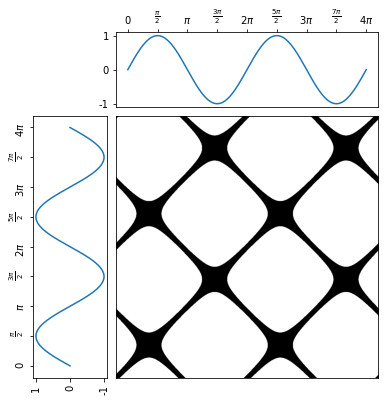

In [ ]:
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot


# Create a toy time series using the sine function
time_points = np.linspace(0, 4 * np.pi, 1000)
x = np.sin(time_points)
X = np.array([x])

# Recurrence plot transformation
rp = RecurrencePlot(threshold=np.pi/18)
X_rp = rp.transform(X)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 4 * np.pi, 9)
time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
                   r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
                   r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
value_ticks = [-1, 0, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(time_points, x)
ax_top.set_xticks(time_ticks)
ax_top.set_xticklabels(time_ticklabels)
ax_top.set_yticks(value_ticks)
ax_top.set_yticklabels(value_ticks)
ax_top.xaxis.tick_top()

# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
             extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.show()

In [ ]:
!pip install git+https://github.com/manu-mannattil/nolitsa.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-z919sebw
  Running command git clone -q https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-z919sebw
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=31147 sha256=5e54ce0ae06ed7d14aef8330ef24018eef129908e8990b25ae74b19534f5eba6
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2orb7dv/wheels/c5/46/b3/cca74fb43c32332828be5f61535e2bb6eba0164287dc4b9e15
Successfully built nolitsa


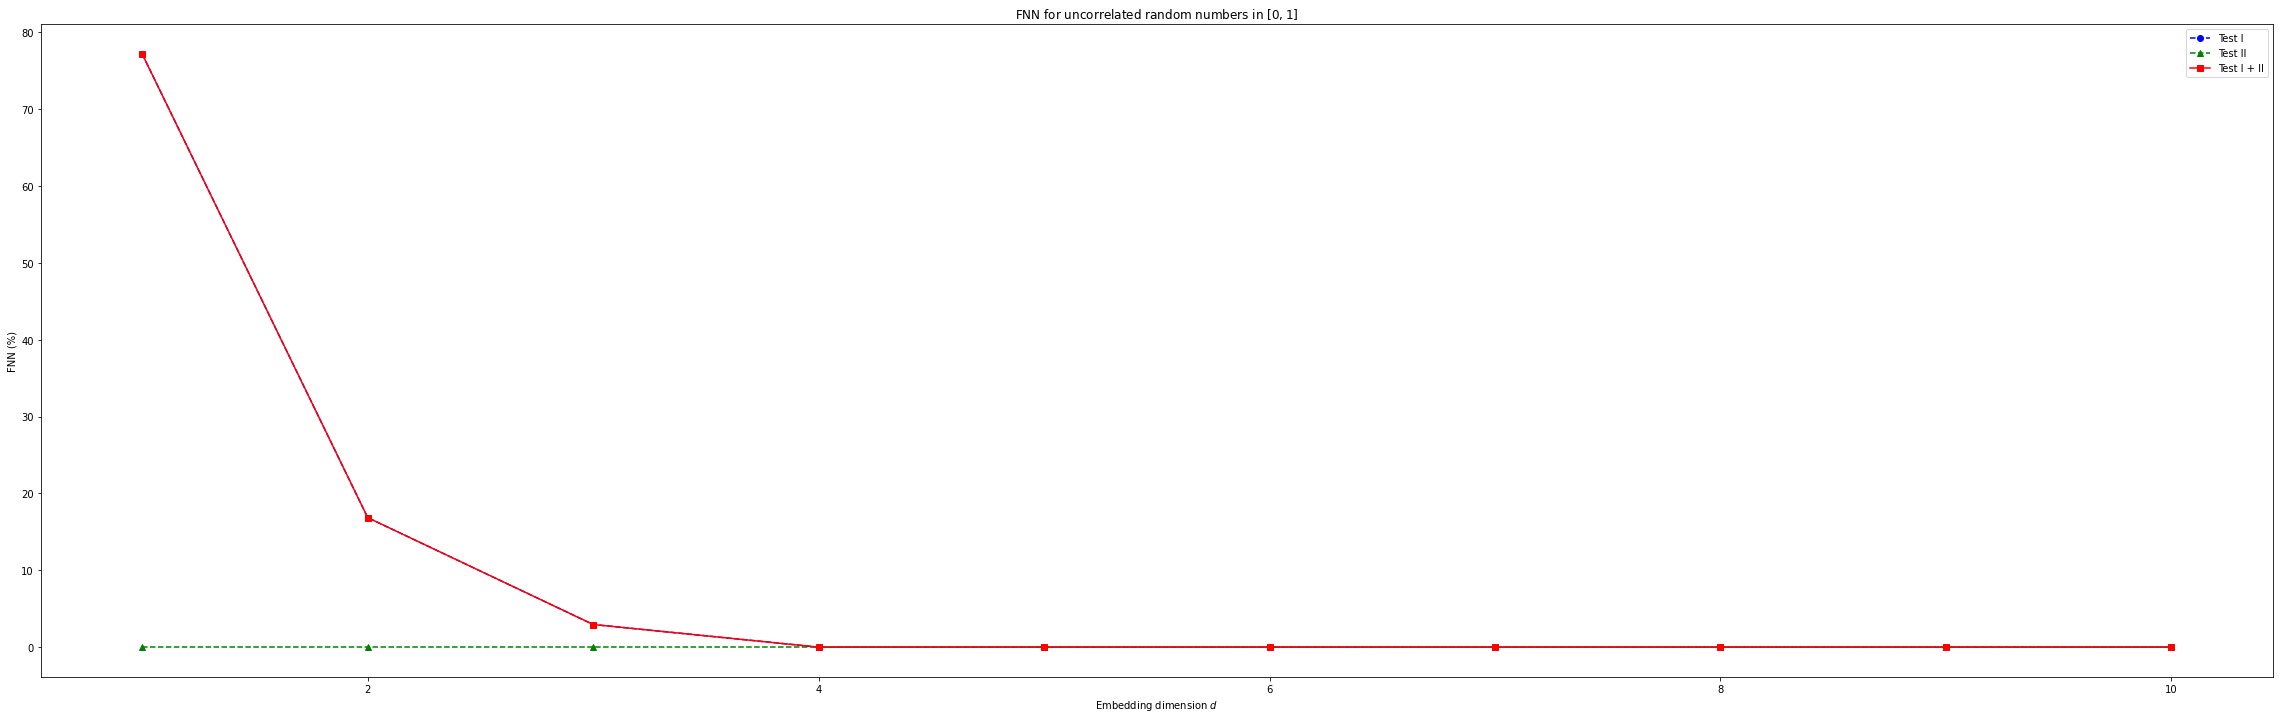

In [ ]:
from nolitsa import dimension
import matplotlib.pyplot as plt
import numpy as np

# Generate data.
x = best_10['BPAC11.SA'].loc[(best_10['BPAC11.SA']!=0) & (best_10['BPAC11.SA']!=1)].dropna().values

dim = np.arange(1, 10 + 1)
f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=2, metric='euclidean')

plt.title(r'FNN for uncorrelated random numbers in $[0, 1]$')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

plt.show()

In [ ]:
best_10['BPAC11.SA'].loc[(best_10['BPAC11.SA']!=0) & (best_10['BPAC11.SA']!=1)].dropna().values

array([0.00583439, 0.00723372, 0.00777784, 0.01023919, 0.01209352,
       0.01104543, 0.00999732, 0.00967482, 0.01007794, 0.01209352,
       0.01088416, 0.01612469, 0.01773718, 0.0216877 , 0.0257189 ,
       0.0289438 , 0.03144311, 0.03144311, 0.03628053, 0.03426495,
       0.02902444, 0.02942755, 0.02942755, 0.02821819, 0.0278957 ,
       0.02579948, 0.03345869, 0.03345869, 0.03071752, 0.03910234,
       0.04152103, 0.04111794, 0.04152103, 0.04071481, 0.04273039,
       0.04353661, 0.0451491 , 0.04539097, 0.04635845, 0.04466536,
       0.04434285, 0.04111794, 0.0399086 , 0.03894108, 0.04111794,
       0.04345603, 0.04402036, 0.04393974, 0.04111794, 0.03628053,
       0.03466806, 0.037893  , 0.04031168, 0.03950548, 0.03910234,
       0.037893  , 0.03861861, 0.04176291, 0.04111794, 0.04256913,
       0.04434285, 0.04281101, 0.04434285, 0.04434285, 0.04434285,
       0.04329479, 0.04273039, 0.04434285, 0.04393974, 0.04224665,
       0.04031168, 0.0399086 , 0.04071481, 0.0399086 , 0.04127

In [ ]:
np.random.random(989)

array([5.09187079e-01, 2.24187410e-01, 8.47343529e-01, 6.92030701e-01,
       5.91153295e-02, 3.47909246e-02, 1.85474125e-01, 6.73113881e-01,
       6.45730273e-02, 8.91761070e-01, 9.85486788e-02, 6.34990338e-01,
       2.02354052e-01, 5.49097163e-01, 8.54921395e-01, 3.10515056e-01,
       6.57422080e-01, 6.63276753e-01, 5.54270647e-01, 2.12769636e-01,
       6.84313332e-01, 8.00918959e-01, 4.36941719e-01, 4.58247293e-01,
       3.09961061e-01, 9.46998310e-01, 6.64276689e-01, 3.04135363e-01,
       3.65528942e-01, 8.39852654e-01, 3.11394465e-02, 8.02744183e-01,
       8.22124480e-01, 3.89540410e-01, 3.93634629e-01, 9.00930386e-01,
       3.67843927e-01, 5.55315904e-01, 8.67223313e-01, 5.54040180e-01,
       7.81369286e-03, 8.32227534e-01, 4.69445852e-01, 8.60610124e-01,
       4.25862989e-01, 5.53216582e-01, 2.26395900e-01, 7.49470304e-01,
       3.04076428e-01, 4.43858119e-01, 2.34605102e-01, 5.09998420e-01,
       8.44497463e-01, 9.54761262e-01, 1.59679116e-01, 7.12350459e-01,
      

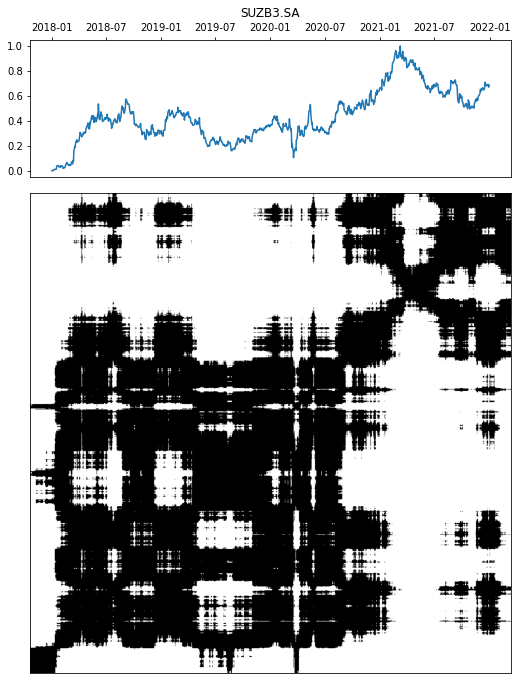

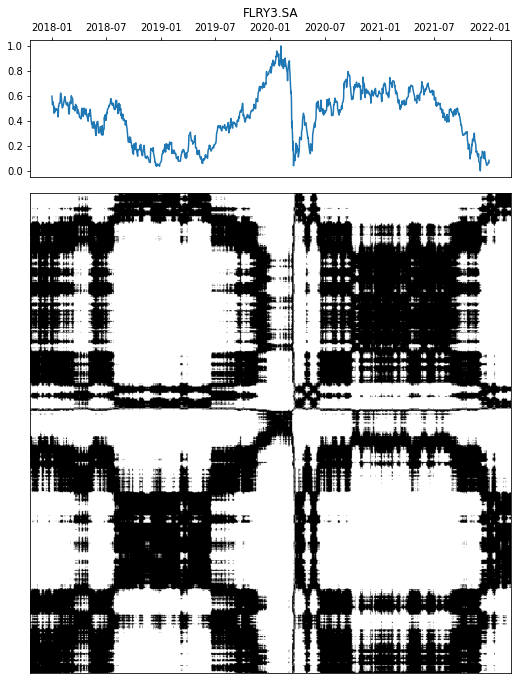

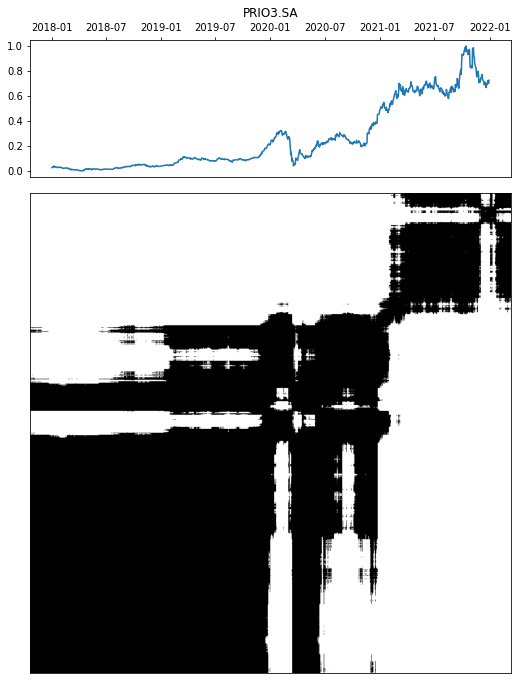

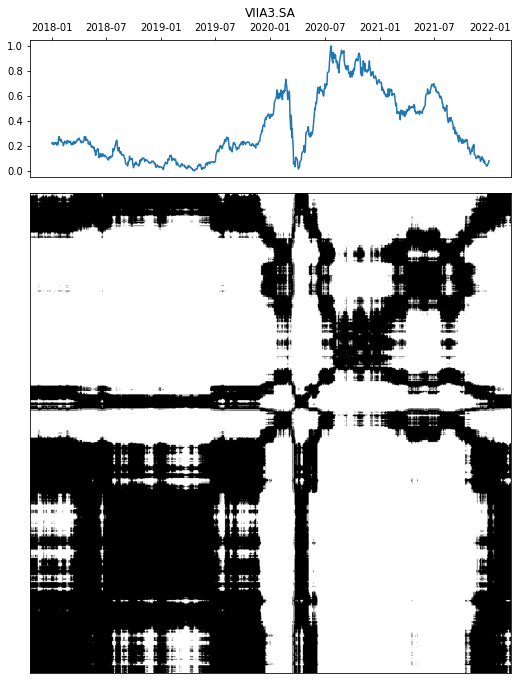

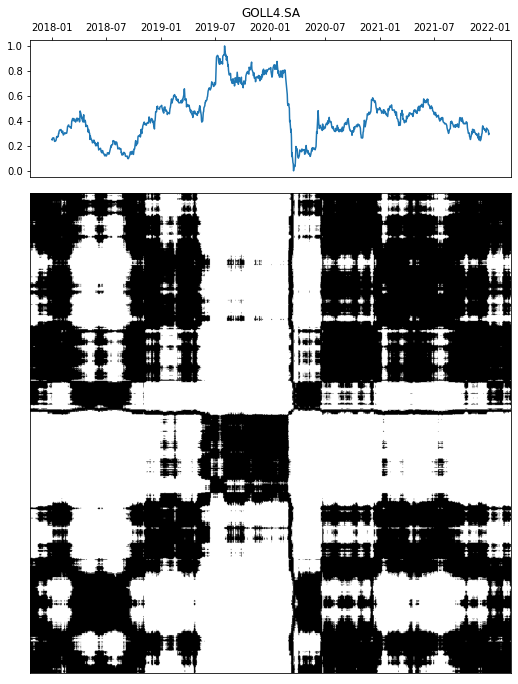

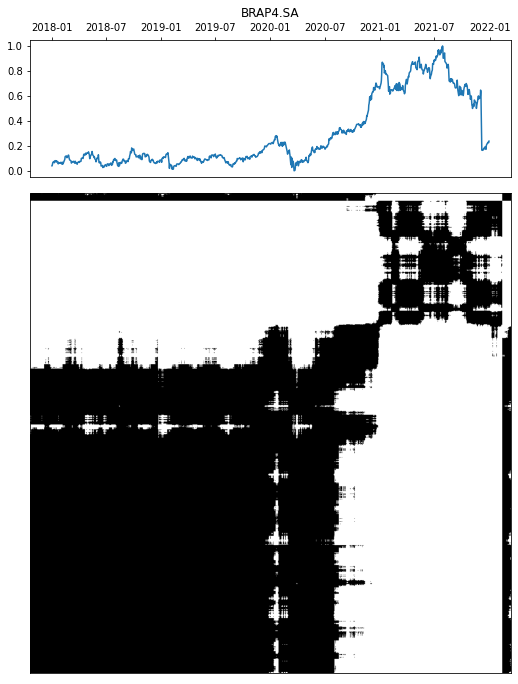

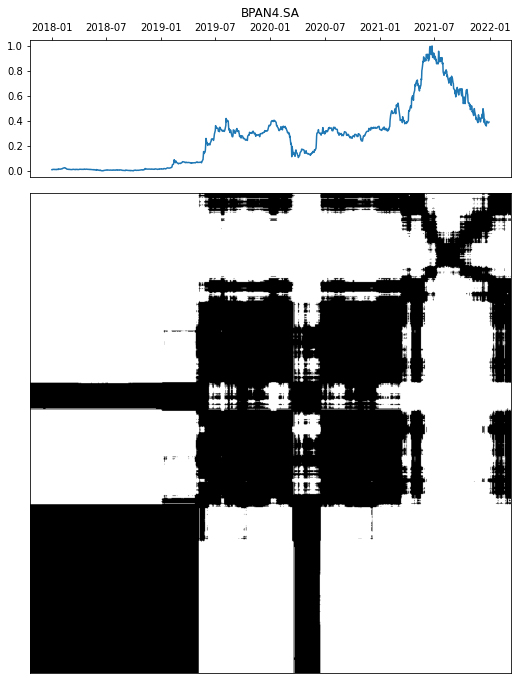

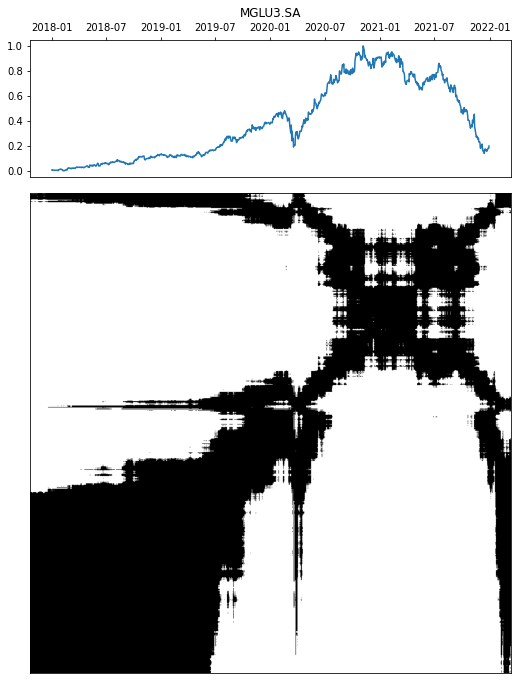

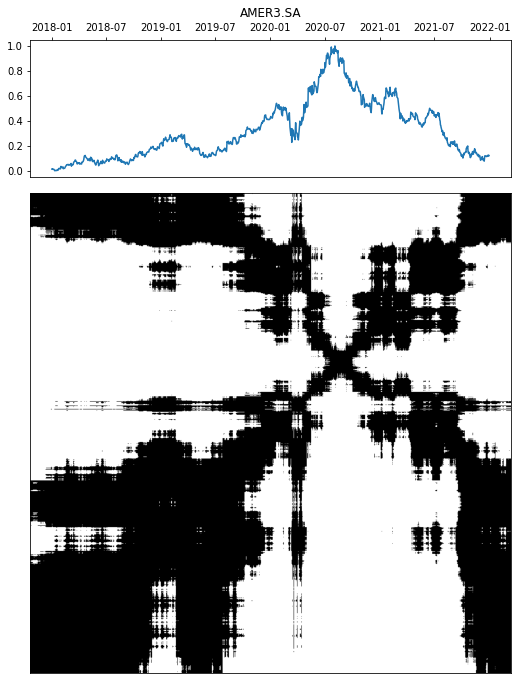

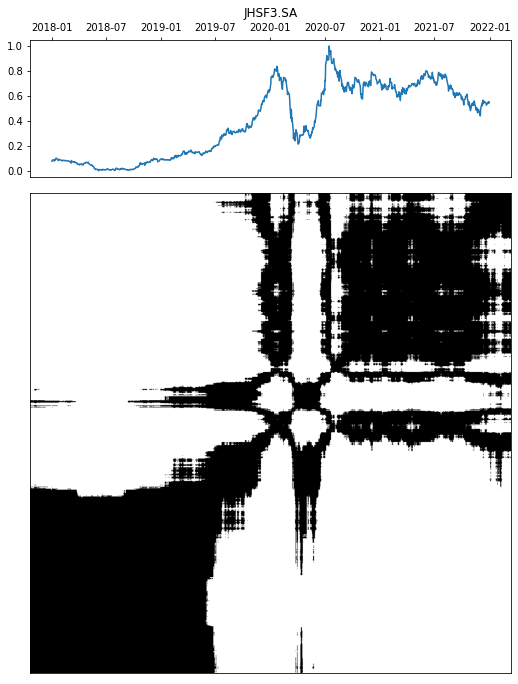

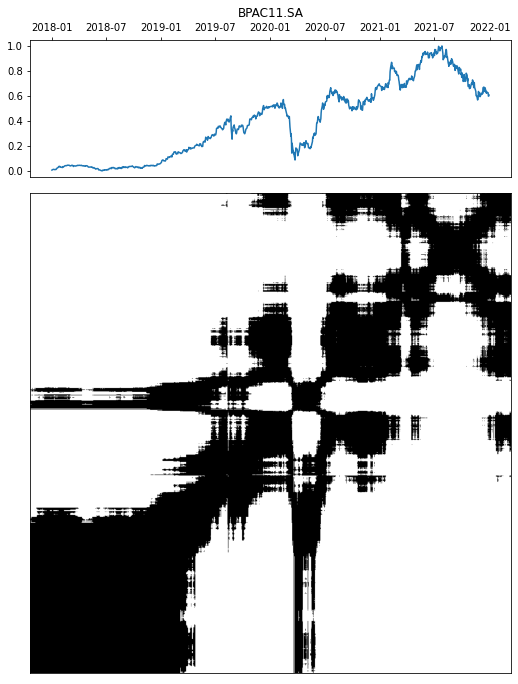

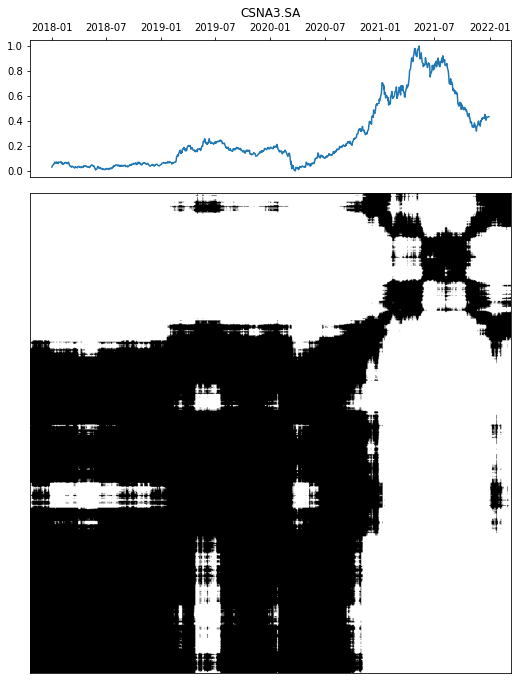

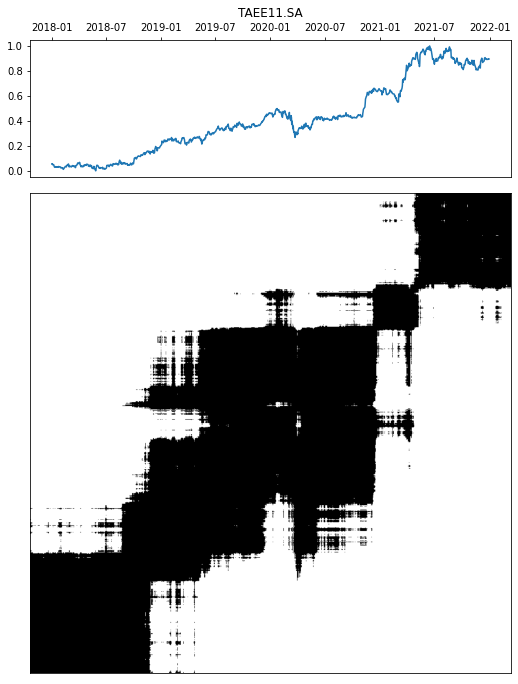

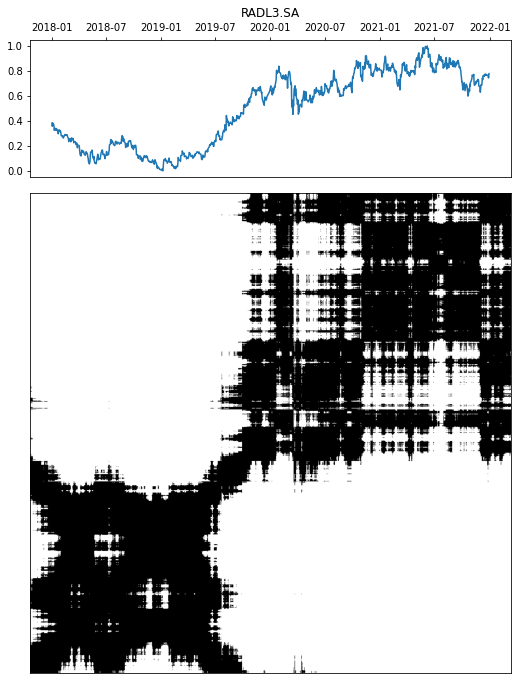

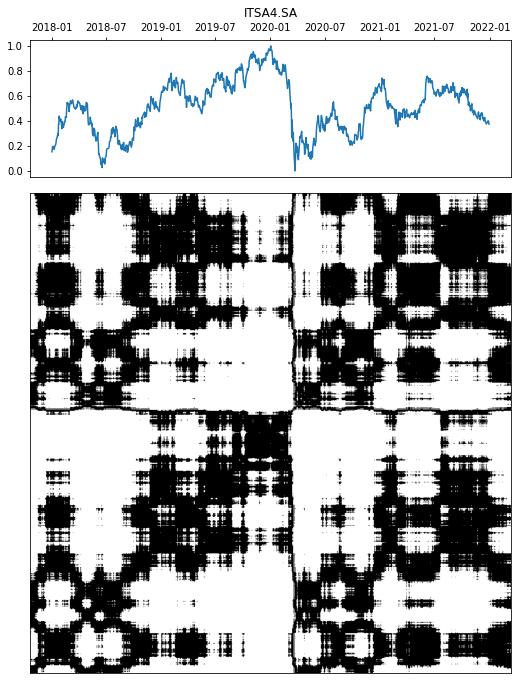

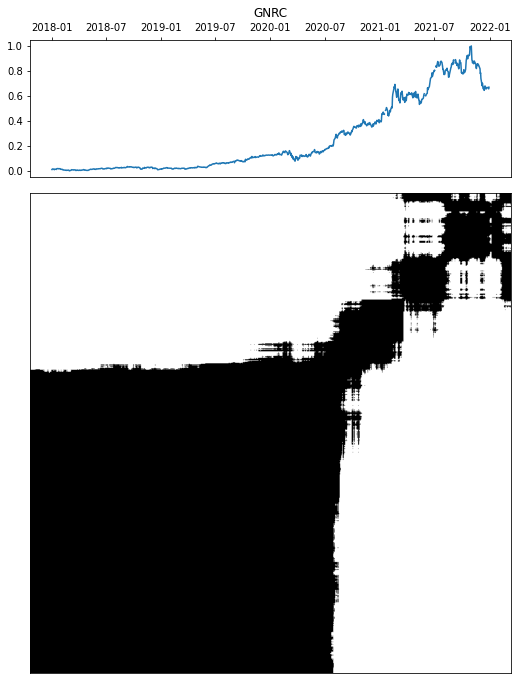

In [ ]:
for stock in best_10.columns:
  X = pd.DataFrame(best_10[stock].dropna().values).T.values

  # Recurrence plot transformation
  rp = RecurrencePlot(threshold=np.pi/18)
  X_rp = rp.transform(X)

  # Plot the time series and its recurrence plot
  fig = plt.figure(figsize=(11, 11))
  gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

  ax_top = fig.add_subplot(gs[0, 1])
  plt.title(stock)
  ax_top.plot(best_10[stock])
  ax_top.xaxis.tick_top()

  # Plot the recurrence plot on the bottom right
  ax_rp = fig.add_subplot(gs[1, 1])
  ax_rp.imshow(X_rp[0], cmap='binary', origin='lower')
  ax_rp.set_xticks([])
  ax_rp.set_yticks([])
  plt.show()

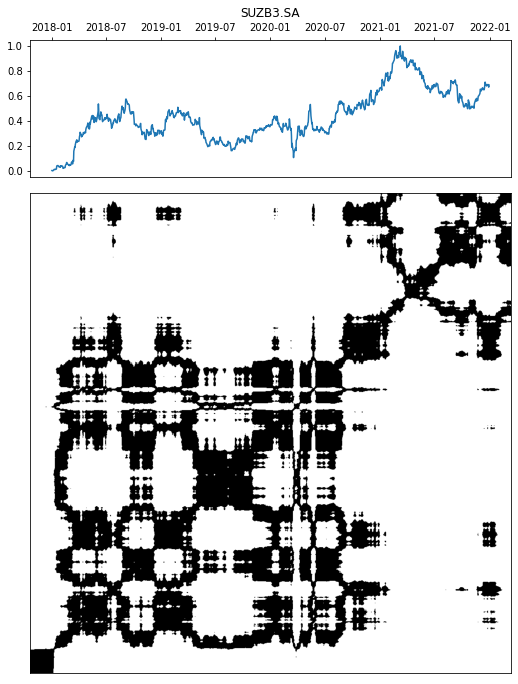

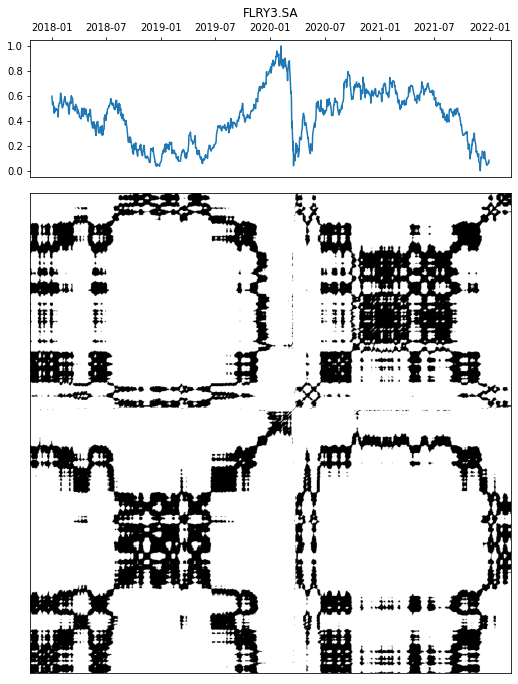

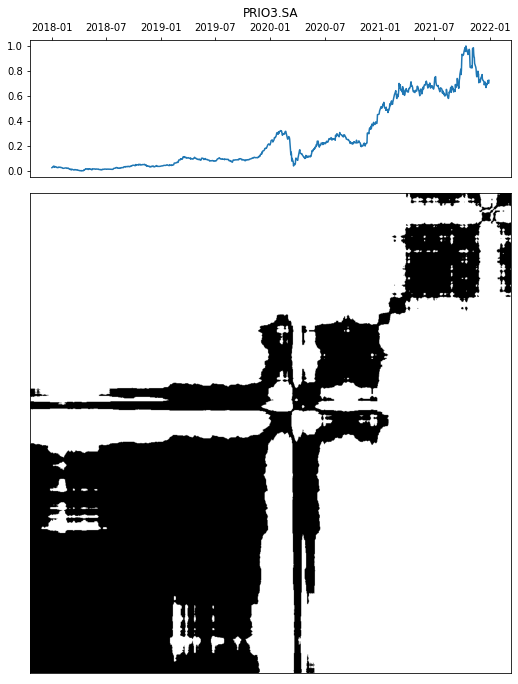

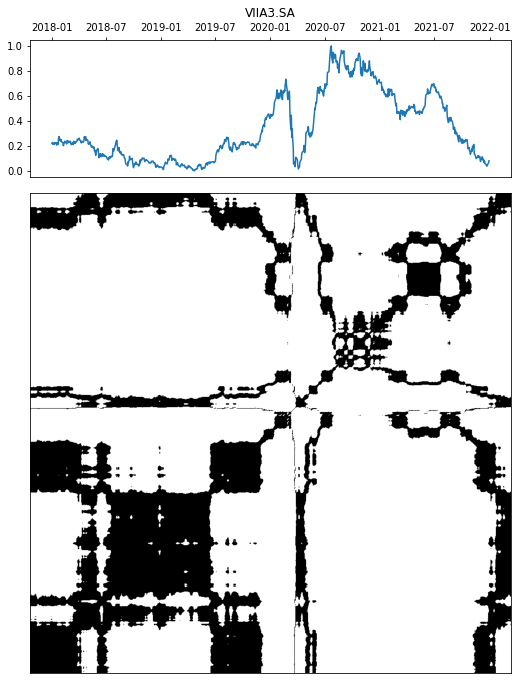

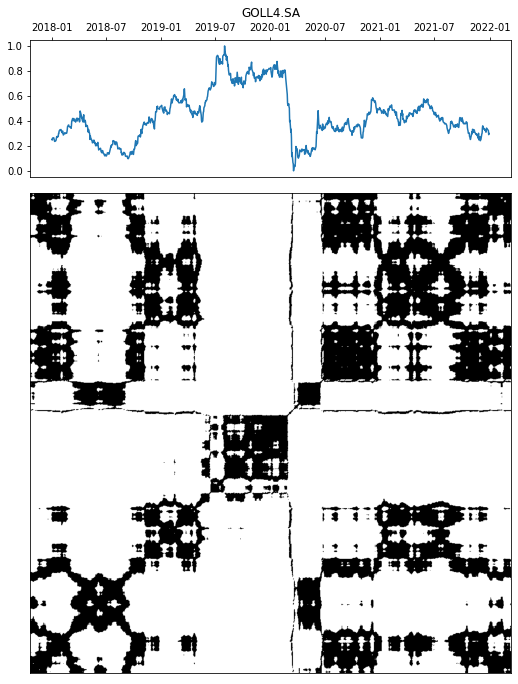

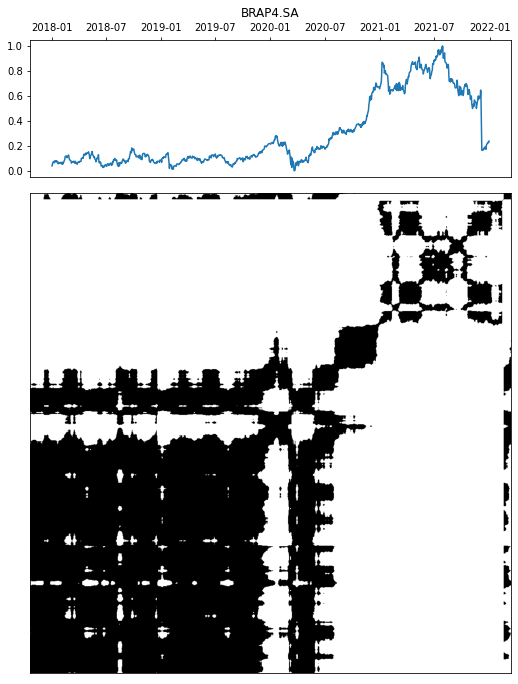

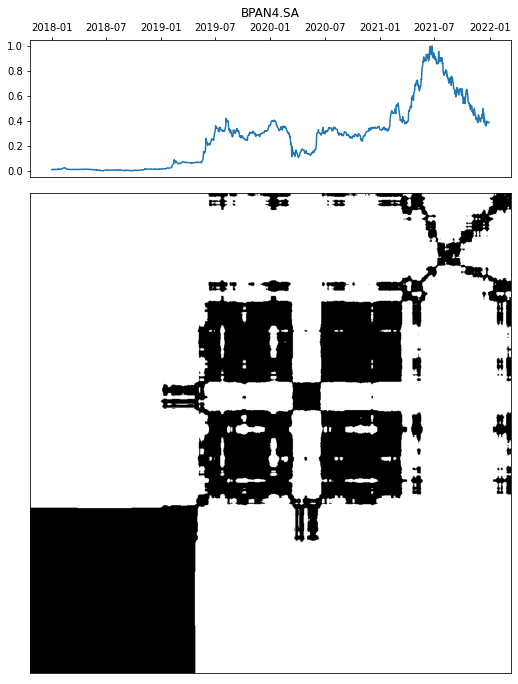

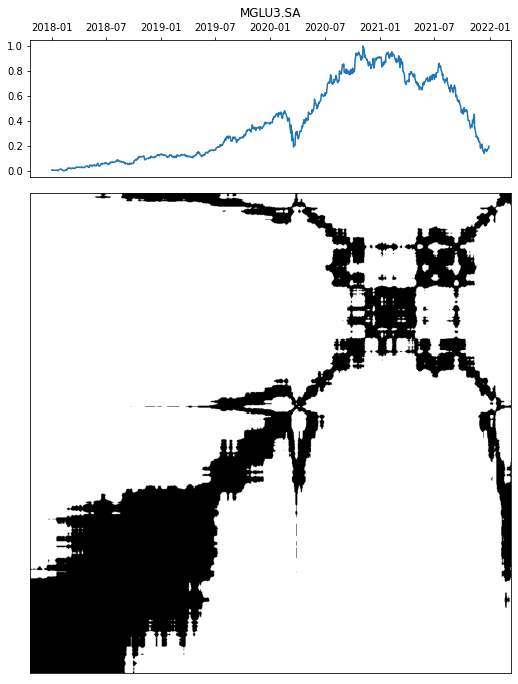

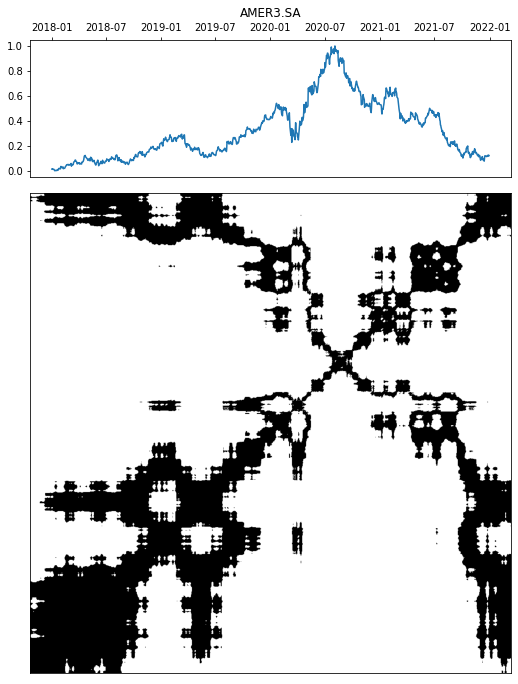

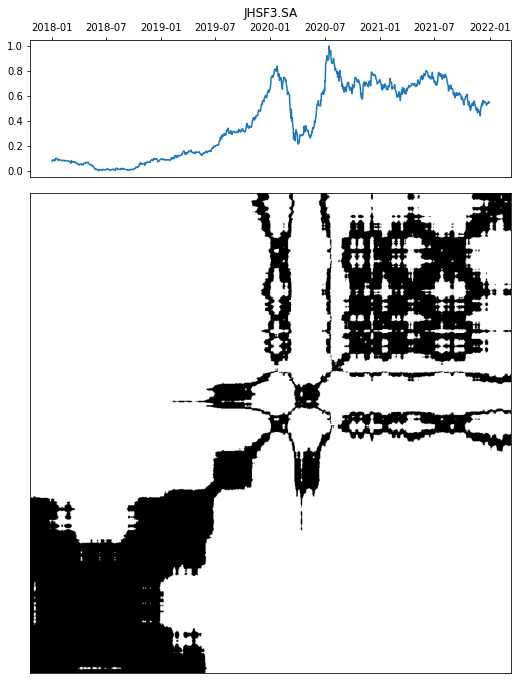

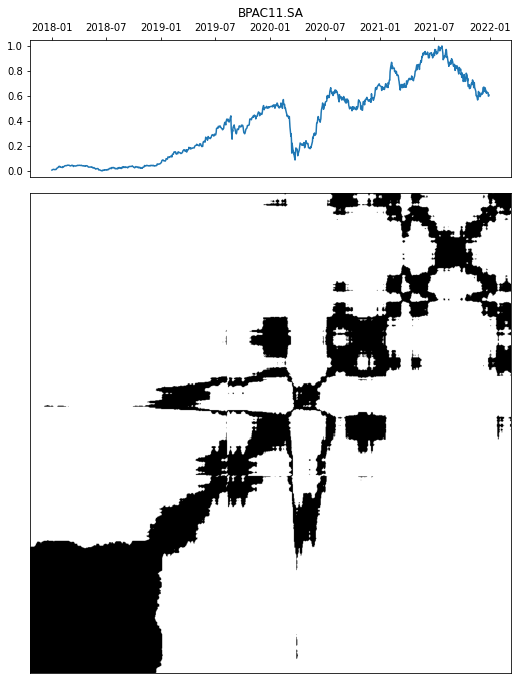

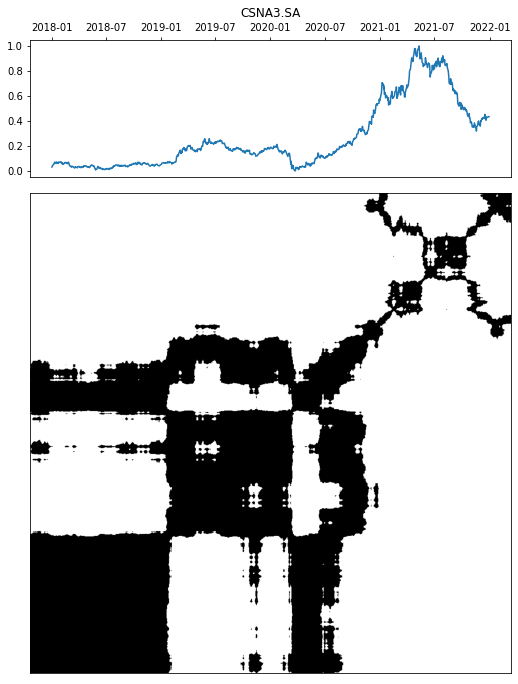

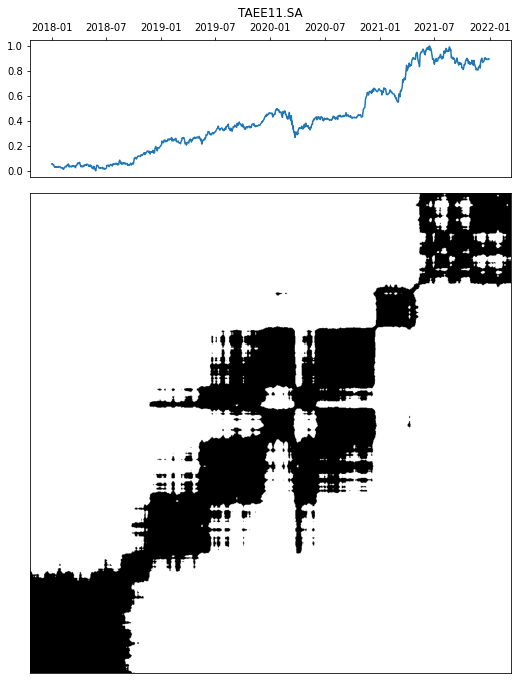

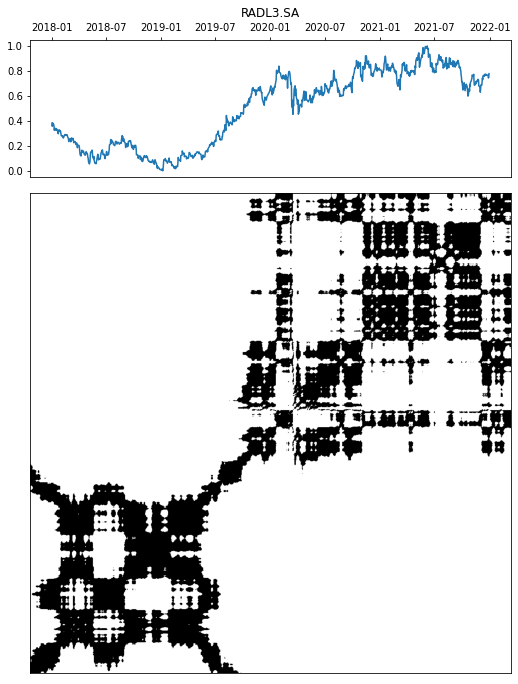

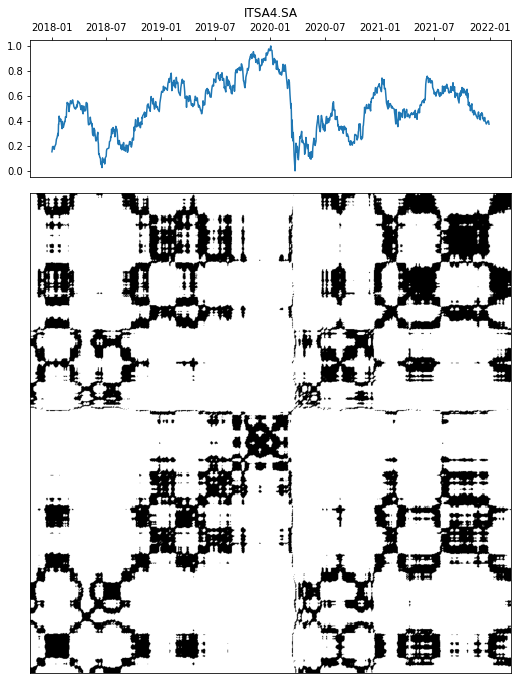

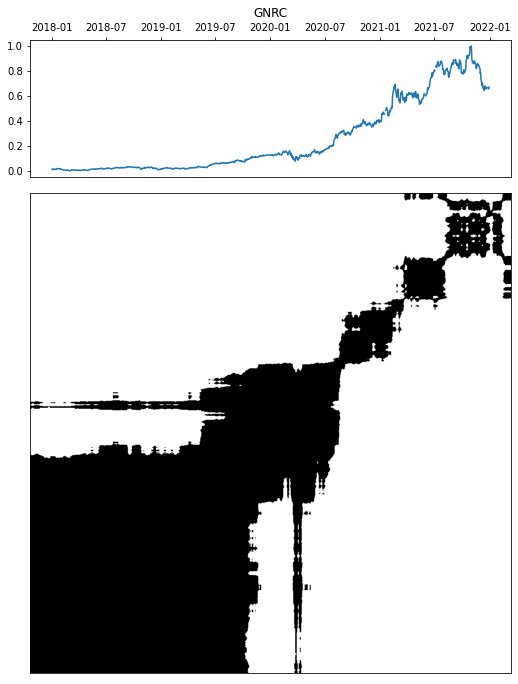

In [ ]:
for stock in best_10.columns:
  X = pd.DataFrame(best_10[stock].dropna().values).T.values

  # Recurrence plot transformation
  rp = RecurrencePlot(threshold=np.pi/18,dimension=4,time_delay=1)
  X_rp = rp.transform(X)

  # Plot the time series and its recurrence plot
  fig = plt.figure(figsize=(11, 11))
  gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

  ax_top = fig.add_subplot(gs[0, 1])
  plt.title(stock)
  ax_top.plot(best_10[stock])
  ax_top.xaxis.tick_top()

  # Plot the recurrence plot on the bottom right
  ax_rp = fig.add_subplot(gs[1, 1])
  ax_rp.imshow(X_rp[0], cmap='binary', origin='lower')
  ax_rp.set_xticks([])
  ax_rp.set_yticks([])
  plt.show()

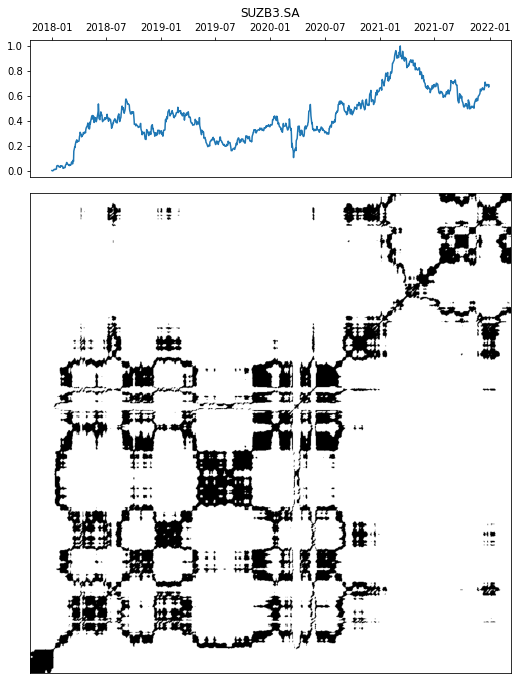

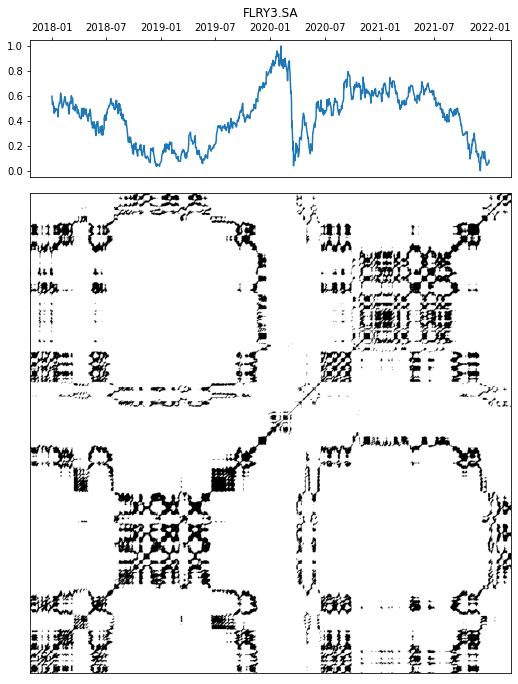

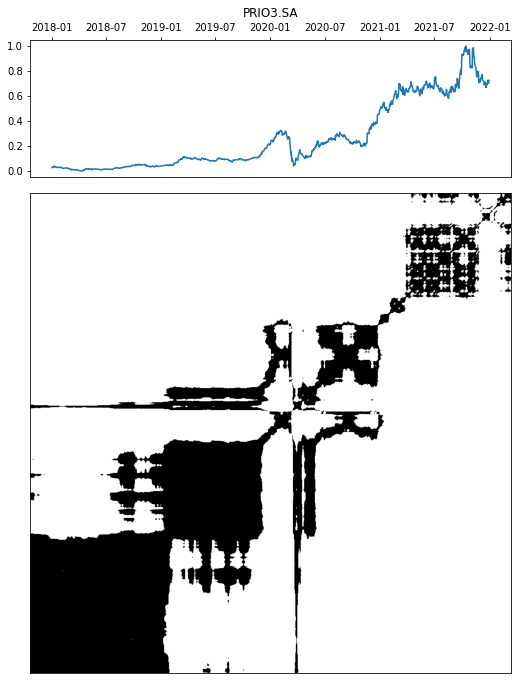

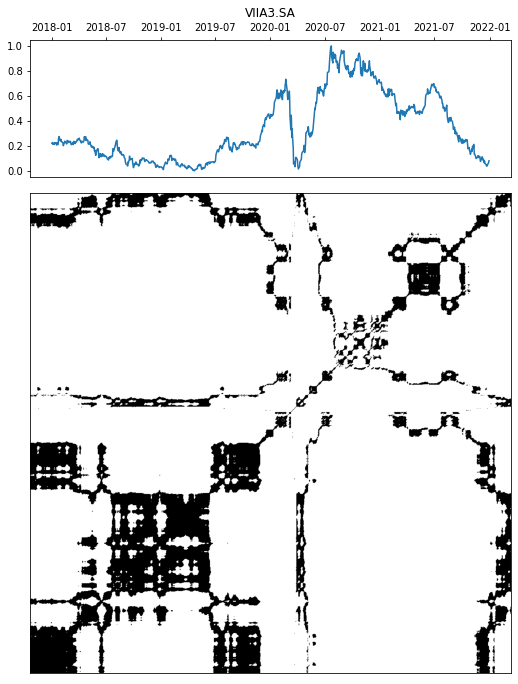

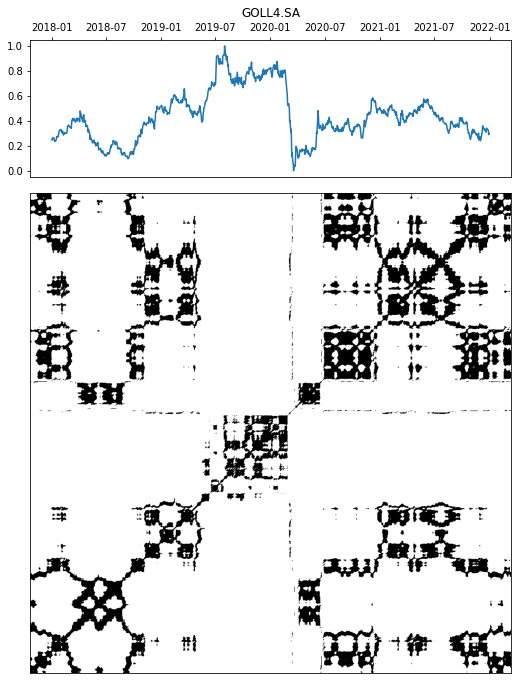

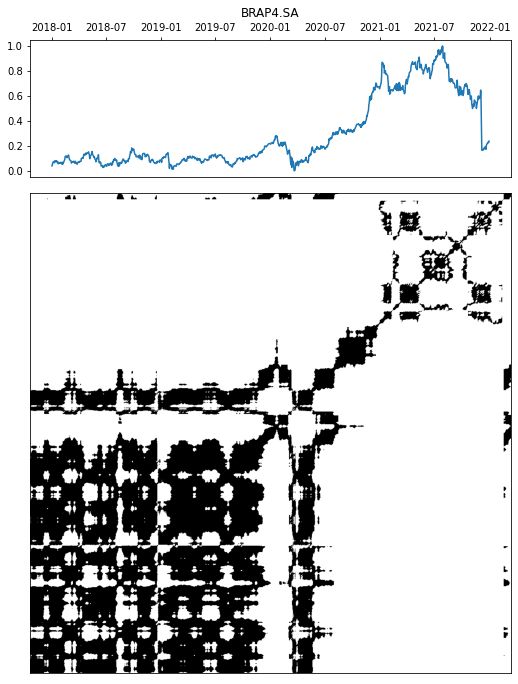

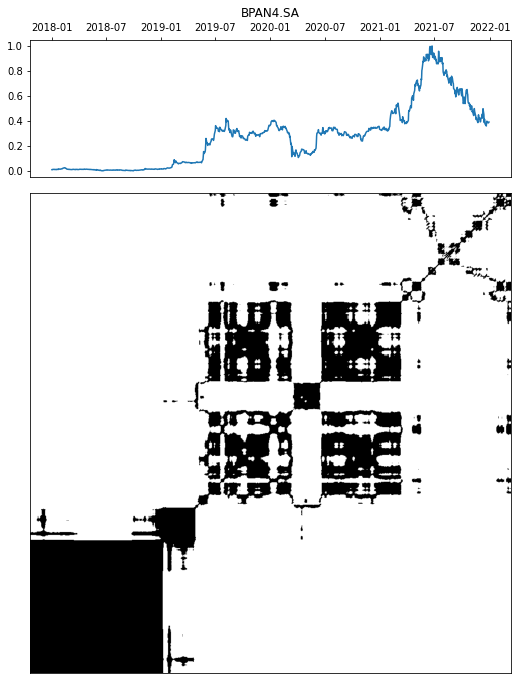

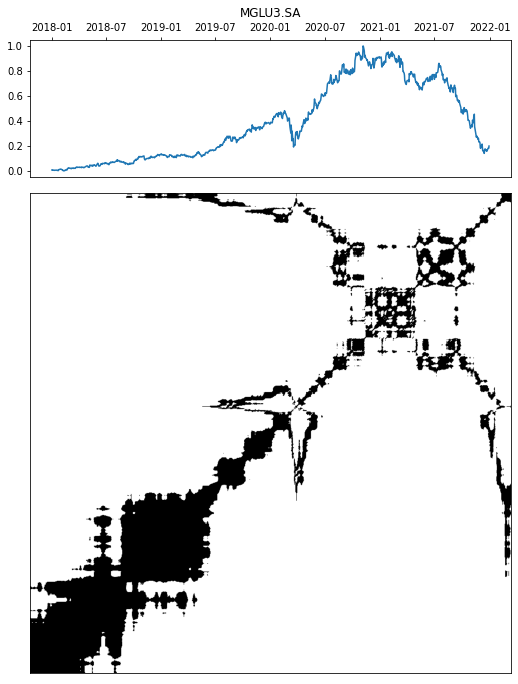

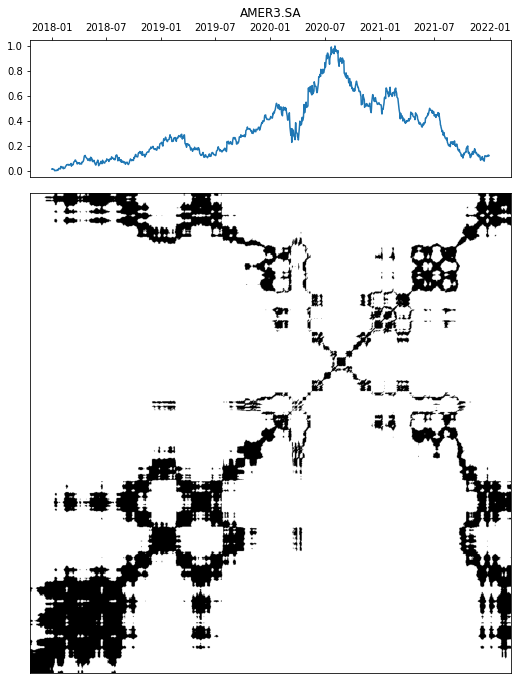

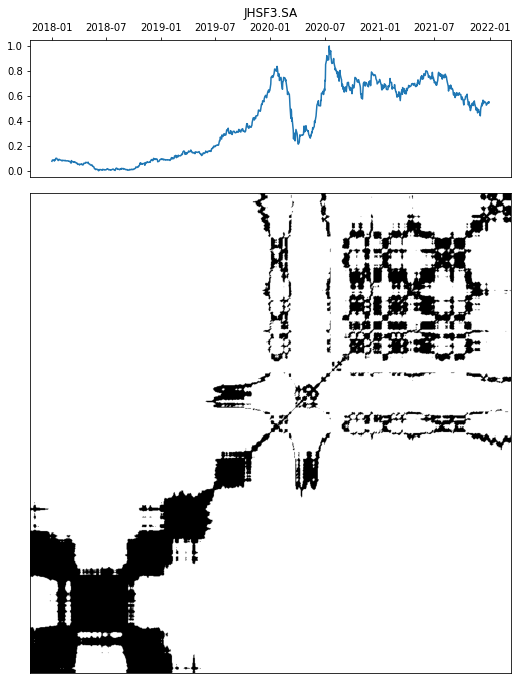

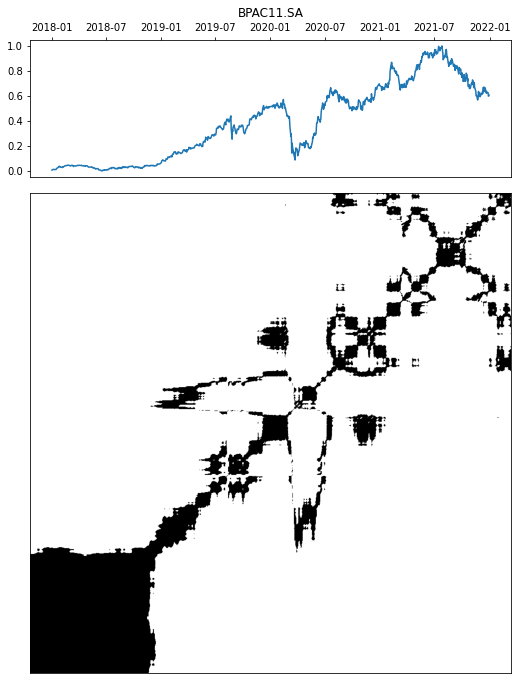

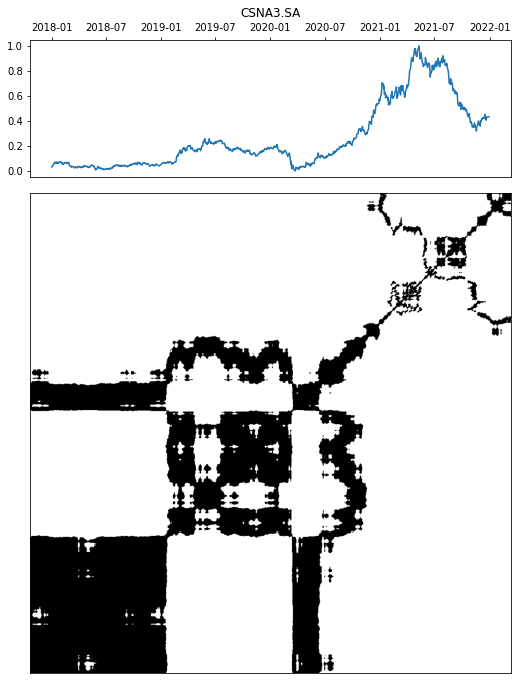

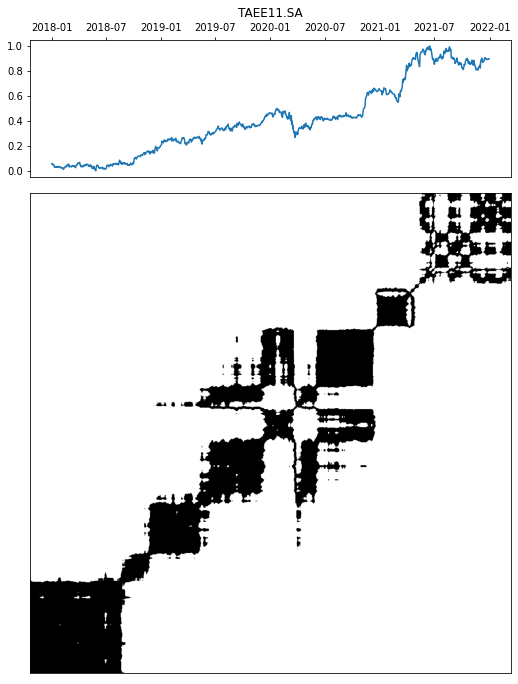

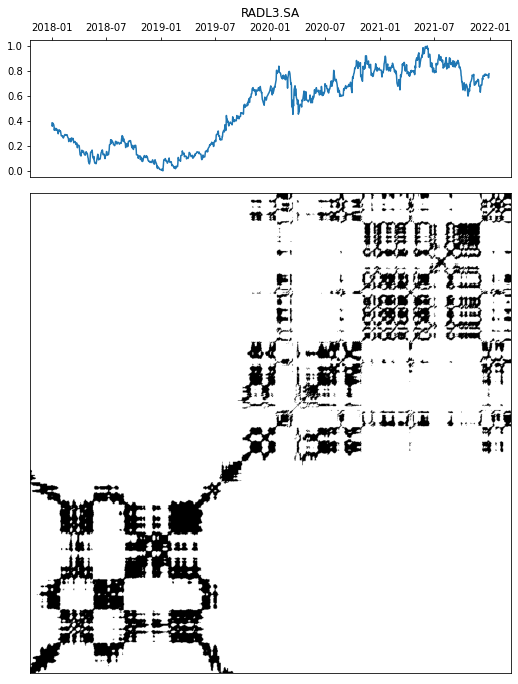

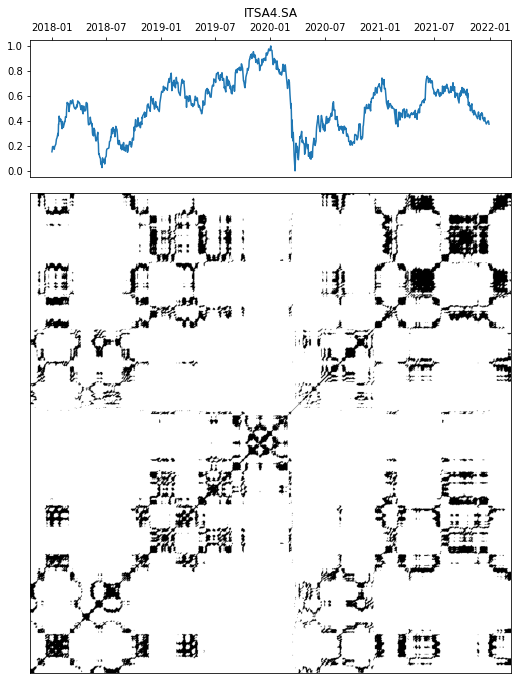

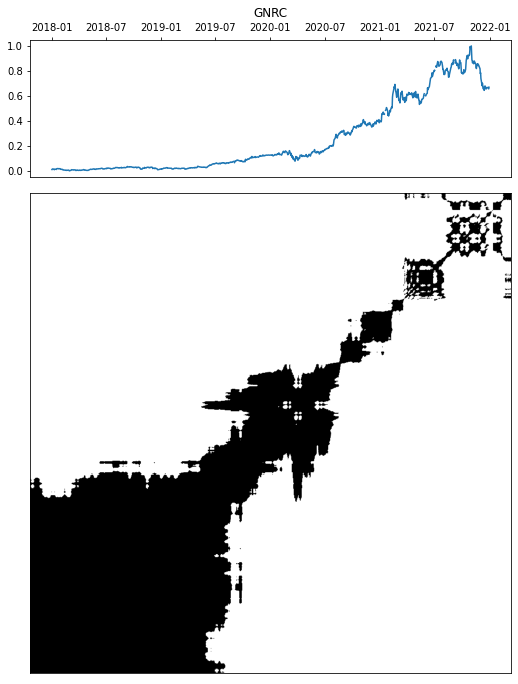

In [ ]:
for stock in best_10.columns:
  X = pd.DataFrame(best_10[stock].dropna().values).T.values

  # Recurrence plot transformation
  rp = RecurrencePlot(threshold=0.1,dimension=4,time_delay=1)
  X_rp = rp.transform(X)

  # Plot the time series and its recurrence plot
  fig = plt.figure(figsize=(11, 11))
  gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

  ax_top = fig.add_subplot(gs[0, 1])
  plt.title(stock)
  ax_top.plot(best_10[stock])
  ax_top.xaxis.tick_top()

  # Plot the recurrence plot on the bottom right
  ax_rp = fig.add_subplot(gs[1, 1])
  ax_rp.imshow(X_rp[0], cmap='binary', origin='lower')
  ax_rp.set_xticks([])
  ax_rp.set_yticks([])
  plt.show()

In [ ]:
!pip install PyRQA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 6.7 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 887 kB 80.4 MB/s 
     |████████████████████████████████| 70 kB 10.6 MB/s 
  Created wheel for PyRQA: filename=PyRQA-8.0.0-py3-none-any.whl size=250250 sha256=f0a3dc8e16394b006befbf2e31958396ce7a414084e337aec78ebddc0c7d8b06
  Stored in directory: /root/.cache/pip/wheels/2b/dc/0f/fc5e8a54ad6dd69a53bd657cd8bf51f26039764b1f68303a2d
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=412a1d38214f4da68038cb62077992072d194fab1858460f9e8c147bac1dd9ef
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built PyRQA pytools


In [ ]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
stock_info_rqa = []

for stock in best_10.columns:
  print('==================================',stock,'==================================')
  print('=============================================================================')
  data_points = best_10[stock].values
  time_series = TimeSeries(data_points,
                          embedding_dimension=4,
                          time_delay=1)
  settings = Settings(time_series,
                      analysis_type=Classic,
                      neighbourhood=FixedRadius(0.65),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=1)
  computation = RQAComputation.create(settings,verbose=False)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2

  stock_info_i = [stock, result.recurrence_rate,result.determinism,result.average_diagonal_line,result.longest_diagonal_line,result.divergence,result.entropy_diagonal_lines,result.laminarity,result.trapping_time]
  stock_info_rqa.append(stock_info_i)
  print(result)

RQAs_best10 = pd.DataFrame(data=stock_info_rqa,columns=['stock','RR','Det','L','LMax','Div','Entropy_DL','LAM','TT'])

================================== SUZB3.SA ==================================
RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.742838
Determinism (DET): 0.999420
Average diagonal line length (L): 91.539243
Longest diagonal line length (L_max): 985
Divergence (DIV): 0.001015
Entropy diagonal lines (L_entr): 4.909846
Laminarity (LAM): 0.999616
Trapping time (TT): 135.645810
Longest vertical line length (V_max): 739
Entropy vertical lines (V_entr): 4.700882
Average white vertical line length (W): 46.694034
Longest white vertical line length (W_max): 737
Longest white vertical line length inverse (W_div): 0.001357
Entropy white vertical lines (W_entr): 4.299798

Ratio determinism / recurrence rate (DET/RR): 1.345409
Ratio laminarity / determinism (LAM/DET): 1.000196

================================== FLRY3.SA ==================================
RQA Result:

Minimum diagonal l

In [ ]:
RQAs_best10

stock        RR       Det           L  LMax       Div  Entropy_DL  \
0    SUZB3.SA  0.742838  0.999420   91.539243   985  0.001015    4.909846   
1    FLRY3.SA  0.691737  0.998487   48.474696   985  0.001015    4.556031   
2    PRIO3.SA  0.630984  0.999664  216.495050   985  0.001015    5.603334   
3    VIIA3.SA  0.592681  0.999510   77.735803   985  0.001015    5.045916   
4    GOLL4.SA  0.733630  0.999233   71.498895   985  0.001015    4.954058   
5    BRAP4.SA  0.623121  0.999802  136.437274   985  0.001015    4.552671   
6    BPAN4.SA  0.681001  0.999428   69.111088   985  0.001015    4.385399   
7    MGLU3.SA  0.533580  0.999305   91.027094   985  0.001015    4.718548   
8    AMER3.SA  0.664465  0.999256   82.063153   985  0.001015    4.895391   
9    JHSF3.SA  0.539436  0.999473   92.108451   985  0.001015    5.145582   
10  BPAC11.SA  0.526548  0.999198   73.645701   985  0.001015    4.720176   
11   CSNA3.SA  0.654450  0.999509  141.289720   985  0.001015    5.226679   
12  TAEE11.SA  0.559249  0.999606  116.266610   985  0.001015    4.795517   
13   RADL3.SA  0.532578  0.999334   91.050776   985  0.001015    4.804629   
14   ITSA4.SA  0.721503  0.998709   54.220431   985  0.001015    4.688604   
15       GNRC  0.495542  0.998024   18.147168    95  0.010526    3.667441   

         LAM          TT  
0   0.999616  135.645810  
1   0.998984   71.235394  
2   0.999817  351.074986  
3   0.999675  123.900839  
4   0.999457  110.983185  
5   0.999842  231.183206  
6   0.999675  119.532418  
7   0.999593  146.312923  
8   0.999483  127.122662  
9   0.999666  150.304759  
10  0.999432  118.265603  
11  0.999711  230.043400  
12  0.999660  178.143232  
13  0.999533  140.862275  
14  0.999063   80.800761  
15  0.999782   34.250089

In [ ]:
best_10.to_excel('best10.xlsx')

In [ ]:
best_10

SUZB3.SA  FLRY3.SA  PRIO3.SA  VIIA3.SA  GOLL4.SA  BRAP4.SA  \
Date                                                                     
2018-01-02  0.002234  0.597493  0.025447  0.221124  0.251113  0.040009   
2018-01-03  0.000000  0.563408  0.026589  0.223413  0.246400  0.043981   
2018-01-04  0.000798  0.529245  0.028808  0.226846  0.261325  0.056039   
2018-01-05  0.000000  0.553394  0.032545  0.212541  0.263420  0.066536   
2018-01-08  0.007182  0.509218  0.037853  0.219979  0.264467  0.074338   
...              ...       ...       ...       ...       ...       ...   
2021-12-23  0.688783  0.043682  0.688553  0.037822  0.335952  0.213684   
2021-12-27  0.691241  0.057343  0.723936  0.058453  0.325740  0.229513   
2021-12-28  0.680097  0.068955  0.701453  0.063610  0.321026  0.225803   
2021-12-29  0.669936  0.061441  0.701453  0.067622  0.289605  0.225556   
2021-12-30  0.687472  0.084665  0.724305  0.080802  0.299293  0.237923   

            BPAN4.SA  MGLU3.SA  AMER3.SA  JHSF3.SA  BPAC11.SA  CSNA3.SA  \
Date                                                                      
2018-01-02  0.009448  0.006480  0.013221  0.076254   0.005834  0.030315   
2018-01-03  0.010211  0.005282  0.011752  0.083186   0.007234  0.036004   
2018-01-04  0.009066  0.007533  0.016710  0.087148   0.007778  0.040982   
2018-01-05  0.010975  0.005641  0.013221  0.087148   0.010239  0.044715   
2018-01-08  0.012120  0.005653  0.011752  0.087148   0.012094  0.052893   
...              ...       ...       ...       ...        ...       ...   
2021-12-23  0.397875  0.157791  0.115044  0.531624   0.624506  0.426110   
2021-12-27  0.383017  0.180831  0.125912  0.546849   0.625220  0.432135   
2021-12-28  0.384291  0.182817  0.117830  0.552706   0.598106  0.432805   
2021-12-29  0.386413  0.180037  0.117738  0.540993   0.598463  0.434813   
2021-12-30  0.390658  0.198309  0.122939  0.551534   0.607025  0.433697   

            TAEE11.SA  RADL3.SA  ITSA4.SA      GNRC  
Date                                                 
2018-01-02   0.056429  0.382253  0.152459  0.010141  
2018-01-03   0.057173  0.356945  0.167801  0.013817  
2018-01-04   0.048738  0.364628  0.192586  0.014553  
2018-01-05   0.051219  0.382253  0.194946  0.015288  
2018-01-08   0.048738  0.369260  0.193766  0.013385  
...               ...       ...       ...       ...  
2021-12-23   0.891033  0.766349  0.383529  0.665895  
2021-12-27   0.894056  0.764598  0.400580  0.667604  
2021-12-28   0.895190  0.743596  0.398874  0.659171  
2021-12-29   0.892545  0.747680  0.390349  0.656468  
2021-12-30   0.895190  0.778017  0.373299  0.669507  

[989 rows x 16 columns]

In [ ]:
#RQA ao longo do tempo
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

stock_info_rqa = []
rolling = 360
for time_space in range(rolling,len(best_10)):
  stock = 'BPAC11.SA'
  print('==================================',best_10.reset_index()['Date'].iloc[time_space],'==================================')
  print('=============================================================================')
  data_points = best_10[stock].loc[(best_10.index <= best_10.reset_index()['Date'].iloc[time_space]) & (best_10.index >= best_10.reset_index()['Date'].iloc[time_space-rolling])].values
  time_series = TimeSeries(data_points,
                          embedding_dimension=4,
                          time_delay=1)
  settings = Settings(time_series,
                      analysis_type=Classic,
                      neighbourhood=FixedRadius(0.65),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=1)
  computation = RQAComputation.create(settings,verbose=False)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2
  
  stock_info_i = [stock,best_10.reset_index()['Date'].iloc[time_space], result.recurrence_rate,result.determinism,result.average_diagonal_line,result.longest_diagonal_line,result.divergence,result.entropy_diagonal_lines,result.laminarity,result.trapping_time]
  stock_info_rqa.append(stock_info_i)
  print(result)

BPAC_RQA = pd.DataFrame(data=stock_info_rqa,columns=['stock','Date','RR','Det','L','LMax','Div','Entropy_DL','LAM','TT'])

Streaming output truncated to the last 5000 lines.
Entropy white vertical lines (W_entr): 3.777828

Ratio determinism / recurrence rate (DET/RR): 1.223357
Ratio laminarity / determinism (LAM/DET): 1.000107

================================== 2021-04-06 00:00:00 ==================================
RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.816657
Determinism (DET): 0.999540
Average diagonal line length (L): 63.035067
Longest diagonal line length (L_max): 357
Divergence (DIV): 0.002801
Entropy diagonal lines (L_entr): 4.569130
Laminarity (LAM): 0.999685
Trapping time (TT): 104.112438
Longest vertical line length (V_max): 318
Entropy vertical lines (V_entr): 4.153227
Average white vertical line length (W): 31.914286
Longest white vertical line length (W_max): 195
Longest white vertical line length inverse (W_div): 0.005128
Entropy white vertical lines (W_entr): 3.761352


In [ ]:
BPAC_RQA

stock       Date        RR       Det           L  LMax       Div  \
0    BPAC11.SA 2019-06-18  1.000000  0.999984  179.500000   357  0.002801   
1    BPAC11.SA 2019-06-19  1.000000  0.999984  179.500000   357  0.002801   
2    BPAC11.SA 2019-06-21  1.000000  0.999984  179.500000   357  0.002801   
3    BPAC11.SA 2019-06-24  1.000000  0.999984  179.500000   357  0.002801   
4    BPAC11.SA 2019-06-25  1.000000  0.999984  179.500000   357  0.002801   
..         ...        ...       ...       ...         ...   ...       ...   
624  BPAC11.SA 2021-12-23  0.887894  0.999260   81.315638   357  0.002801   
625  BPAC11.SA 2021-12-27  0.888471  0.999278   81.370158   357  0.002801   
626  BPAC11.SA 2021-12-28  0.888986  0.999313   81.187411   357  0.002801   
627  BPAC11.SA 2021-12-29  0.889142  0.999331   81.087143   357  0.002801   
628  BPAC11.SA 2021-12-30  0.888799  0.999278   81.167382   357  0.002801   

     Entropy_DL       LAM          TT  
0      5.874932  1.000000  358.000000  
1      5.874932  1.000000  358.000000  
2      5.874932  1.000000  358.000000  
3      5.874932  1.000000  358.000000  
4      5.874932  1.000000  358.000000  
..          ...       ...         ...  
624    4.770939  0.999490  134.920522  
625    4.765282  0.999491  135.168646  
626    4.772766  0.999482  135.406659  
627    4.779783  0.999473  135.429251  
628    4.764392  0.999473  135.216152  

[629 rows x 10 columns]

In [ ]:
BPAC_RQA.to_excel('BPAC_RQA_360.xlsx')

Text(0.5, 1.0, 'Rolling 90d')

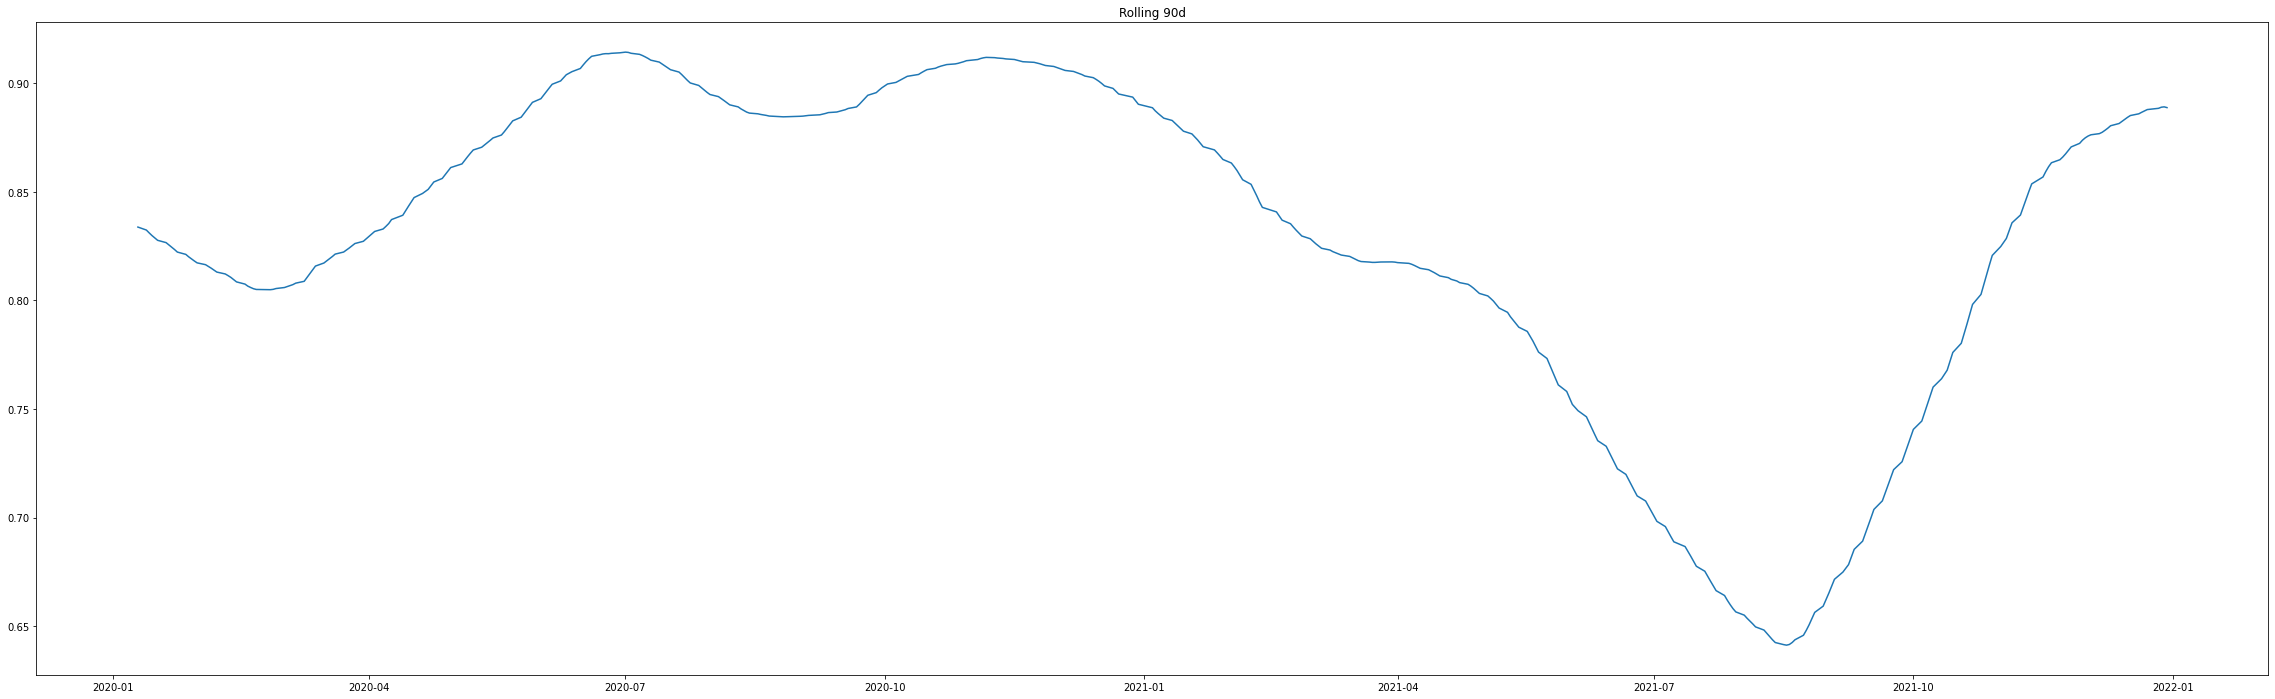

In [ ]:
plt.plot(BPAC_RQA.loc[BPAC_RQA['Date']>='2020-01-10'].set_index('Date')['RR'])
plt.title('Rolling 90d')

Text(0.5, 1.0, 'Rolling 180d')

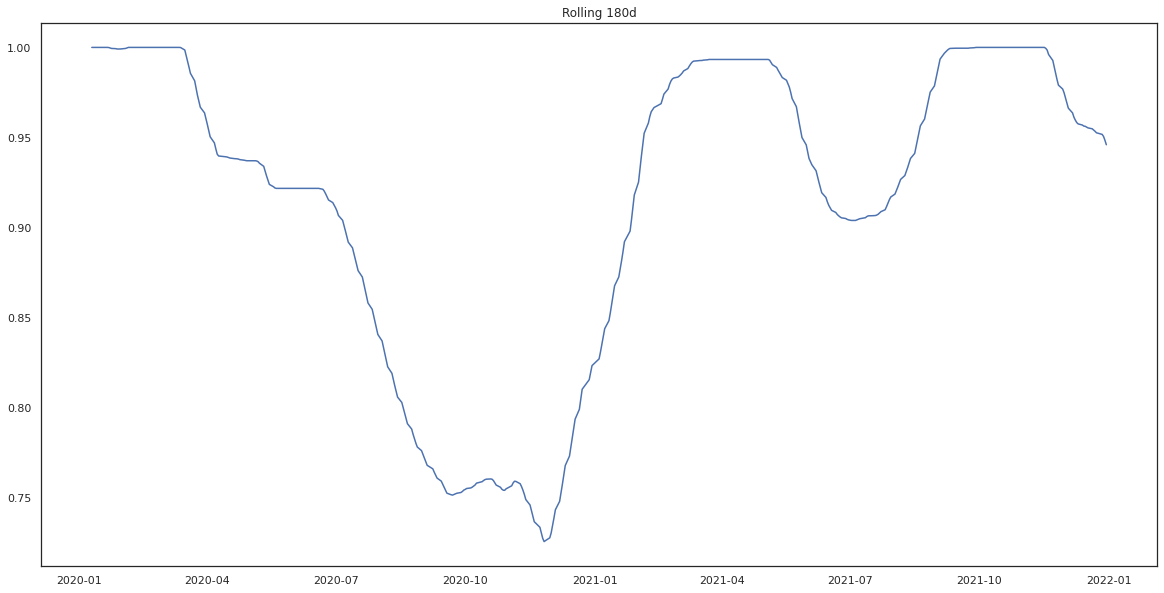

In [ ]:
plt.plot(BPAC_RQA.loc[BPAC_RQA['Date']>='2020-01-10'].set_index('Date')['RR'])
plt.title('Rolling 180d')

Text(0.5, 1.0, 'Rolling 360d')

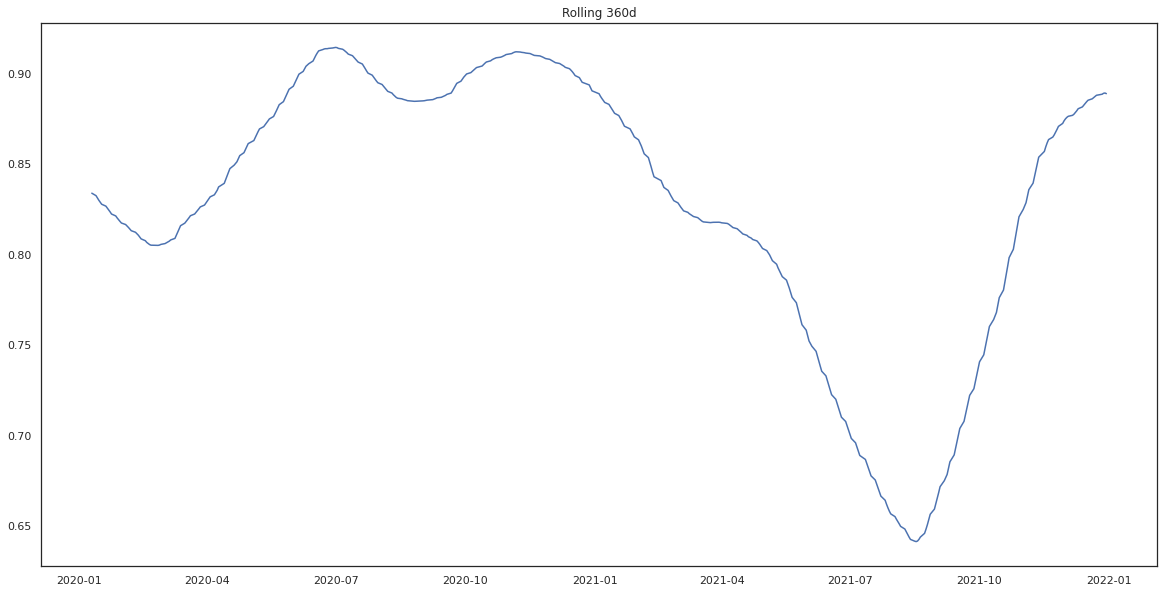

In [ ]:
plt.plot(BPAC_RQA.loc[BPAC_RQA['Date']>='2020-01-10'].set_index('Date')['RR'])
plt.title('Rolling 360d')

Text(0.5, 1.0, 'Rolling 500d')

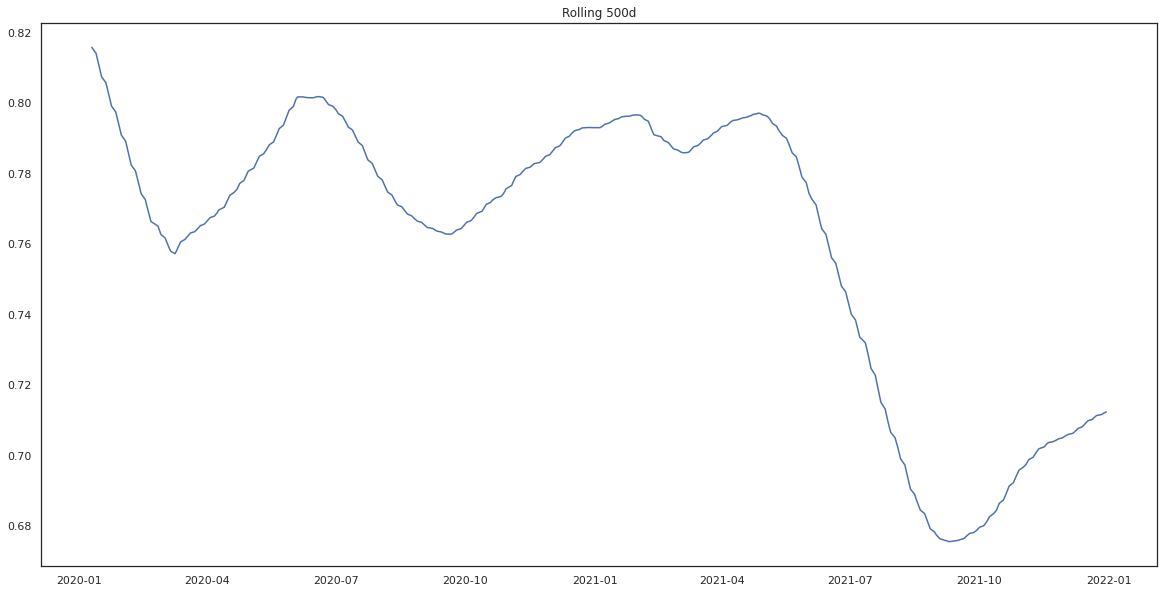

In [ ]:
plt.plot(BPAC_RQA.loc[BPAC_RQA['Date']>='2020-01-10'].set_index('Date')['RR'])
plt.title('Rolling 500d')

In [ ]:
#RQA ao longo do tempo
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

stock_info_rqa = []
rolling = 90
for time_space in range(rolling,len(best_10)):
  stock = 'BPAC11.SA'
  print('==================================',best_10.reset_index()['Date'].iloc[time_space],'==================================')
  print('=============================================================================')
  data_points = best_10[stock].loc[(best_10.index <= best_10.reset_index()['Date'].iloc[time_space]) & (best_10.index >= best_10.reset_index()['Date'].iloc[time_space-rolling])].values
  time_series = TimeSeries(data_points,
                          embedding_dimension=2,
                          time_delay=2)
  settings = Settings(time_series,
                      analysis_type=Classic,
                      neighbourhood=FixedRadius(0.65),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=1)
  computation = RQAComputation.create(settings,verbose=False)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2
  
  stock_info_i = [stock,best_10.reset_index()['Date'].iloc[time_space], result.recurrence_rate,result.determinism,result.average_diagonal_line,result.longest_diagonal_line,result.divergence,result.entropy_diagonal_lines,result.laminarity,result.trapping_time]
  stock_info_rqa.append(stock_info_i)
  print(result)

BPAC_RQA = pd.DataFrame(data=stock_info_rqa,columns=['stock','Date','RR','Det','L','LMax','Div','Entropy_DL','LAM','TT'])

Streaming output truncated to the last 5000 lines.
Entropy white vertical lines (W_entr): 0.000000

Ratio determinism / recurrence rate (DET/RR): 0.999745
Ratio laminarity / determinism (LAM/DET): 1.000255

================================== 2021-04-06 00:00:00 ==================================
RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 1.000000
Determinism (DET): 0.999745
Average diagonal line length (L): 45.000000
Longest diagonal line length (L_max): 88
Divergence (DIV): 0.011364
Entropy diagonal lines (L_entr): 4.465909
Laminarity (LAM): 1.000000
Trapping time (TT): 89.000000
Longest vertical line length (V_max): 89
Entropy vertical lines (V_entr): 0.000000
Average white vertical line length (W): nan
Longest white vertical line length (W_max): 0
Longest white vertical line length inverse (W_div): inf
Entropy white vertical lines (W_entr): 0.000000

Ratio determini

In [ ]:
BPAC_RQA.to_excel('BPAC_RQA_90d.xlsx')

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [ ]:
BPAC_RQA#.to_excel('BPAC_RQA.xls')

stock       Date        RR       Det           L  LMax       Div  \
0    BPAC11.SA 2019-06-18  1.000000  0.999984  179.500000   357  0.002801   
1    BPAC11.SA 2019-06-19  1.000000  0.999984  179.500000   357  0.002801   
2    BPAC11.SA 2019-06-21  1.000000  0.999984  179.500000   357  0.002801   
3    BPAC11.SA 2019-06-24  1.000000  0.999984  179.500000   357  0.002801   
4    BPAC11.SA 2019-06-25  1.000000  0.999984  179.500000   357  0.002801   
..         ...        ...       ...       ...         ...   ...       ...   
624  BPAC11.SA 2021-12-23  0.887894  0.999260   81.315638   357  0.002801   
625  BPAC11.SA 2021-12-27  0.888471  0.999278   81.370158   357  0.002801   
626  BPAC11.SA 2021-12-28  0.888986  0.999313   81.187411   357  0.002801   
627  BPAC11.SA 2021-12-29  0.889142  0.999331   81.087143   357  0.002801   
628  BPAC11.SA 2021-12-30  0.888799  0.999278   81.167382   357  0.002801   

     Entropy_DL       LAM          TT  
0      5.874932  1.000000  358.000000  
1      5.874932  1.000000  358.000000  
2      5.874932  1.000000  358.000000  
3      5.874932  1.000000  358.000000  
4      5.874932  1.000000  358.000000  
..          ...       ...         ...  
624    4.770939  0.999490  134.920522  
625    4.765282  0.999491  135.168646  
626    4.772766  0.999482  135.406659  
627    4.779783  0.999473  135.429251  
628    4.764392  0.999473  135.216152  

[629 rows x 10 columns]

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Trapping time')

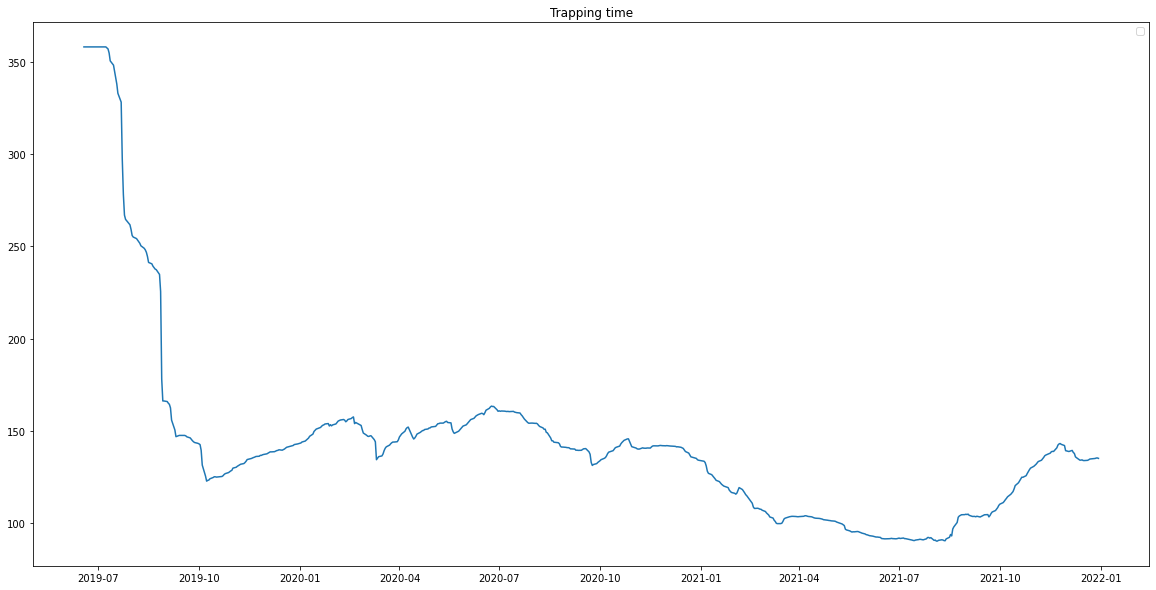

In [ ]:
plt.plot(BPAC_RQA.set_index('Date')[['TT']])
plt.legend()
plt.title('Trapping time')

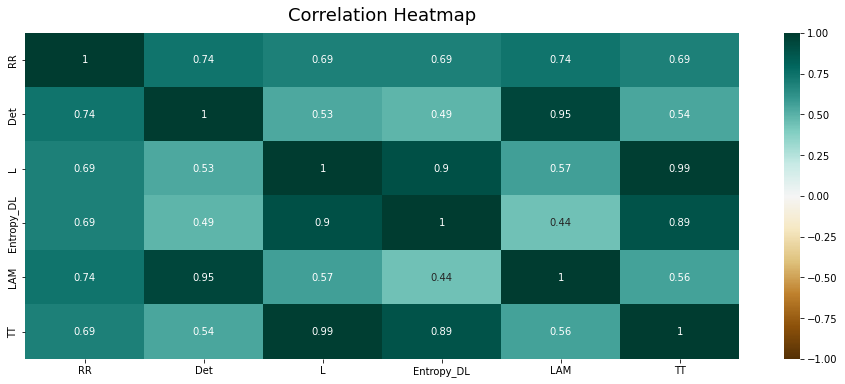

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(BPAC_RQA.drop(['LMax','Div'],axis='columns').corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
BPAC_RQA.corr()

RR       Det         L  LMax  Div  Entropy_DL       LAM  \
RR          1.000000  0.524970  0.717032   NaN  NaN    0.438320  0.587470   
Det         0.524970  1.000000  0.802591   NaN  NaN    0.732078  0.992013   
L           0.717032  0.802591  1.000000   NaN  NaN    0.915995  0.848548   
LMax             NaN       NaN       NaN   NaN  NaN         NaN       NaN   
Div              NaN       NaN       NaN   NaN  NaN         NaN       NaN   
Entropy_DL  0.438320  0.732078  0.915995   NaN  NaN    1.000000  0.755026   
LAM         0.587470  0.992013  0.848548   NaN  NaN    0.755026  1.000000   
TT          0.671034  0.856542  0.990157   NaN  NaN    0.924230  0.896415   

                  TT  
RR          0.671034  
Det         0.856542  
L           0.990157  
LMax             NaN  
Div              NaN  
Entropy_DL  0.924230  
LAM         0.896415  
TT          1.000000

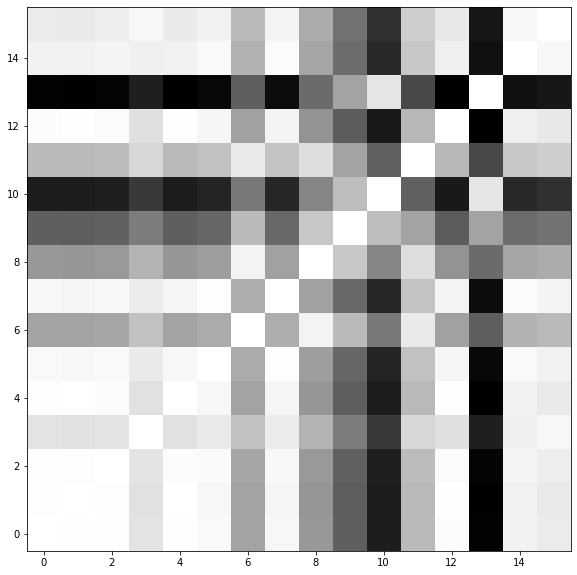

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

# Parameters
#n_samples, n_features = 100, 144

# Toy dataset
#rng = np.random.RandomState(41)
#X = rng.randn(n_samples, n_features)
X = best_10.dropna().values
# Recurrence plot transformation
rp = RecurrencePlot(dimension=1,
                    percentage=20)
X_rp = rp.fit_transform(X) 

# Show the results for the first time series
plt.figure(figsize=(10, 10))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show() 